# 以热卷 hc2001 为例策略研发

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline 

import datetime
import talib
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from numba import *
import numpy as np

mpl.style.use('seaborn-whitegrid')
pd.set_option('display.width', 21250)
pd.set_option('display.max_columns', 21250)
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False


## 获得tick数据

In [4]:

    
def get_tick_csv(tick_file):
    
    print(tick_file)
    df_days_instrument_one_by_one = pd.read_csv(tick_file, header=0,

                                                error_bad_lines=False, low_memory=False,
                                                na_filter=True, verbose=False,
                                                skip_blank_lines=True,
                                                engine='c',
                                                warn_bad_lines=True, chunksize=100000,
                                                iterator=True)
    df = pd.concat(df_days_instrument_one_by_one, ignore_index=True)
    print(df)
    df = df[["logtime", "InstrumentID", "LastPrice", "Volume", "Turnover", "OpenInterest",
             "BidPrice1", "BidVolume1", "AskPrice1", "AskVolume1", 
            'TradingDay','UpdateTime','UpdateMillisec']]
    
    index = pd.DatetimeIndex(pd.to_datetime(df['logtime'], format="%Y%m%d%H%M%S%f", errors='coerce'))
    df.set_index(index, inplace= True)
    df.index.set_names(['datetime'], inplace=True)
    df.dropna(inplace=True)
    
    return df


In [5]:

hc2001_file = r'.\hc2001.csv'
hc2001_df = get_tick_csv(hc2001_file)


.\hc2001.csv
                 logtime InstrumentID  TradingDay UpdateTime  UpdateMillisec  OpenPrice  HighestPrice  LowestPrice  LastPrice  Volume      Turnover  OpenInterest  AveragePrice  LowerLimitPrice  UpperLimitPrice  BidPrice1  BidVolume1  AskPrice1  AskVolume1
0      20190910205900583       hc2001    20190911   20:59:00             500     3522.0        3522.0       3522.0     3522.0     794  2.796468e+07      522276.0      35220.00           3318.0           3741.0     3521.0           4     3522.0          40
1      20190910210000580       hc2001    20190911   21:00:00             500     3522.0        3522.0       3521.0     3521.0     812  2.859848e+07      522278.0      35219.80           3318.0           3741.0     3520.0          11     3521.0           9
2      20190910210001082       hc2001    20190911   21:00:01               0     3522.0        3522.0       3519.0     3521.0     928  3.268208e+07      522334.0      35217.76           3318.0           3741.0     3519.

## 把交易按连续性分为多个交易段

In [6]:


def remark_data_time_phase(row):
    if (row.UpdateTime >= "09:00:00" and row.UpdateTime < "10:15:00") \
        or (row.UpdateTime >= "10:30:00" and row.UpdateTime < "11:30:00"):
        return 1

    elif (row.UpdateTime >= "13:30:00" and row.UpdateTime < "15:00:00"):
        return 2
    elif (row.UpdateTime >= "21:00:00" and row.UpdateTime <= "22:59:59"):
        #or (row.UpdateTime >= "00:00:00" and row.UpdateTime <= "02:30:00"):
        return 3
    else:
        return -1


def remark_date_time_by_index(row):
    timeStr = str(row["logtime"])
    dt = datetime.datetime.strptime(timeStr, '%Y%m%d%H%M%S%f')
    log_datetime = int(dt.strftime('%Y%m%d'))
    return log_datetime


def secondofday(time):
    t = time.split(':')
    return int(t[0]) * 3600 + int(t[1]) * 60 + int(t[2])

### 按日期来分段

In [7]:

hc2001_df["date_phase"] = hc2001_df.apply(remark_date_time_by_index, axis=1)

### 按交易时间来分段

In [8]:
hc2001_df["SecondOfDay"] = hc2001_df["UpdateTime"].apply(secondofday)

hc2001_df["date_time_phase"] = hc2001_df.apply(remark_data_time_phase, axis=1)
hc2001_df = hc2001_df[hc2001_df.date_time_phase > 0]  # only keep valid data


## 此处应当做成循环，按每个时间段处理

In [9]:
hc2001_df.head()

,logtime,InstrumentID,LastPrice,Volume,Turnover,OpenInterest,BidPrice1,BidVolume1,AskPrice1,AskVolume1,TradingDay,UpdateTime,UpdateMillisec,date_phase,SecondOfDay,date_time_phase
datetime,,,,,,,,,,,,,,,,
2019-09-10 21:00:00.580,20190910210000580,hc2001,3521.0,812,28598480.0,522278.0,3520.0,11,3521.0,9,20190911,21:00:00,500,20190910,75600,3
2019-09-10 21:00:01.082,20190910210001082,hc2001,3521.0,928,32682080.0,522334.0,3519.0,4,3520.0,5,20190911,21:00:01,0,20190910,75601,3
2019-09-10 21:00:01.584,20190910210001584,hc2001,3525.0,1272,44796360.0,522312.0,3521.0,2,3524.0,4,20190911,21:00:01,500,20190910,75601,3
2019-09-10 21:00:02.086,20190910210002086,hc2001,3522.0,1344,47332480.0,522306.0,3522.0,1,3523.0,13,20190911,21:00:02,0,20190910,75602,3
2019-09-10 21:00:02.586,20190910210002586,hc2001,3521.0,1386,48811460.0,522316.0,3520.0,13,3522.0,7,20190911,21:00:02,500,20190910,75602,3


tick_date_phase = hc2001_df.groupby(hc2001_df["date_phase"])
for df_phase_date, df_phase_date_ticks in tick_date_phase:
    #print(df_phase_date, df_phase_date_ticks)
    df_phase_date_ticks_cp = df_phase_date_ticks#.copy()
    tick_df1_date_time_phase = df_phase_date_ticks_cp.groupby(df_phase_date_ticks_cp["date_time_phase"])
    for df_phase_date_time, df_phase_date_time_ticks in tick_df1_date_time_phase:
        #print("df_phase_date_time,", df_phase_date_time,",df_phase_date_time_ticks: \n",df_phase_date_time_ticks[:1])
        #todo 本来应该是循环，此处仅适用最后一个时间段
        tick_df1_one = df_phase_date_time_ticks

tick_df1_one

### 挑选一个时间段

In [10]:

hc2001_df_one = hc2001_df[ (hc2001_df["date_time_phase"] == 1) & (hc2001_df["date_phase"] == 20190911) ]


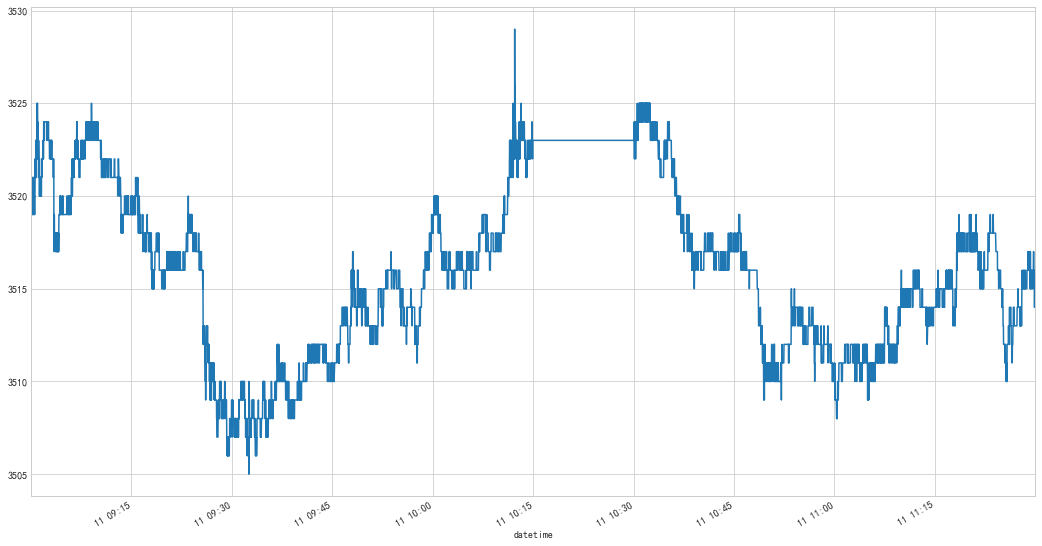

In [11]:

fig, ax = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
hc2001_df_one["LastPrice"].plot(ax=ax)
plt.show()

### Ask Bid价差

In [12]:

hc2001_df_one["spread"] = hc2001_df_one["AskPrice1"] - hc2001_df_one["BidPrice1"]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


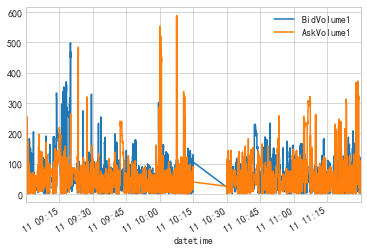

In [13]:
hc2001_df_one[['BidVolume1', 'AskVolume1']].plot()

### Ask Bid 挂单中间价， 价差

In [14]:
hc2001_df_one["mid_price"] = (hc2001_df_one['BidPrice1'] + hc2001_df_one['AskPrice1']) / 2
hc2001_df_one["dmid_price"] = hc2001_df_one["mid_price"].diff().fillna(0)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## 订单不平衡对价格的影响

统计一段时间某个方向的订单不平衡积累分布和后期价格的影响

如果当前出价低于之前的出价，
这意味着交易者取消了他的买入限价订单或者订单以t-1买入价填补。
由于我们没有更细化的订单或消息簿，我们无法确定交易者的意图，
因此我们保守地设定BidVolume1_Imbalance_t = 0。

如果当前出价与之前的价格相同，
我们采用出价量的差异来表示上一期间的增量购买压力。

最后，如果当前的出价高于之前的价格，
由于交易商打算以更高的价格购买，我们可以将其解释为价格上涨动力。
向下价格动量和卖出压力可以类似于当前和之前的要价来解释。我们称之为订单量不平衡（VOI）：

If the current bid price is lower than the previous bid price, 
that implies that either the trader cancelled his buy limit order or an order was filled at the t-1 bid price. 
As we do not have a more granular order or message book, we cannot be certain of the trader intent,
hence we conservatively set BidVolume1_Imbalance_t = 0. 
If the current bid price is the same as the previous price, 
we take the difference of the bid volume to represent incremental buying pressure from the last period. 

Lastly, if the current bid price is greater than the previous price, 
we can interpret this as upward price momentum due to the trader’s intent to buy at a higher price. 
Downward price momentum and sell pressure can be interpreted analogously from the current and previous ask prices.
which we will call Volume Order Imbalance (VOI):

### 具体：

$$
V^B_t=
\begin{cases}
0,&P^B_t<P^B_{t-1} \\ 
V^B_t-V^B_{t-1},&P^B_t=P^B_{t-1} \\
V^B_t,&P^B_t>P^B_{t-1}
\end{cases}
$$

$$
V^A_t=
\begin{cases}
V^A_t,&P^A_t<P^A_{t-1} \\ 
V^A_t-V^A_{t-1},&P^A_t=P^A_{t-1} \\
0,&P^A_t>P^A_{t-1}
\end{cases}
$$



$$
VOI_t=V^B_t-V^A_t
$$



In [15]:
def get_bid_cv(bv, sbv, dbp):
    if dbp == 0:
        return bv - sbv
    elif dbp < 0:
        return 0
    else:
        return bv

def get_ask_cv(av, sav, dap):
    if dap == 0:
        return av - sav
    elif dap < 0:
        return av
    else:
        return 0

In [16]:

# diff of Price
hc2001_df_one["dBid_price"] = hc2001_df_one['BidPrice1'].diff().fillna(0)
hc2001_df_one["dAsk_price"] = hc2001_df_one['AskPrice1'].diff().fillna(0)

#Volume Order Imbalance 

## build order imbalance signal according to Spec
# 为了方便在同一个row里面计算而组装   Page_5
df = pd.concat([hc2001_df_one['BidVolume1'], hc2001_df_one['BidVolume1'].shift(1).fillna(0), hc2001_df_one["dBid_price"]], axis=1)
df.columns = ['bv', 'sbv', 'dbp']

df['bid_CV'] = df.apply(lambda row : get_bid_cv(row['bv'], row['sbv'], row['dbp']), axis=1)
hc2001_df_one["bid_CV"] = df['bid_CV']
    
# 为了方便在同一个row里面计算而组装
df = pd.concat([hc2001_df_one['AskVolume1'], hc2001_df_one['AskVolume1'].shift(1).fillna(0), hc2001_df_one["dAsk_price"]], axis=1)
df.columns = ['av', 'sav', 'dap']


df['ask_CV'] = df.apply(lambda row : get_ask_cv(row['av'], row['sav'], row['dap']), axis=1)
hc2001_df_one["ask_CV"] = df['ask_CV']

hc2001_df_one["VOI"] = hc2001_df_one["bid_CV"] - hc2001_df_one["ask_CV"]
hc2001_df_one['DeltaVOI'] = hc2001_df_one.VOI.diff()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

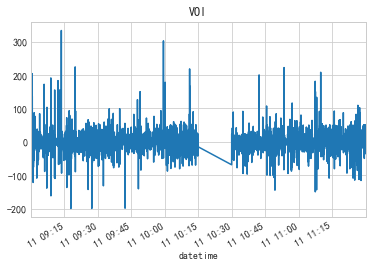

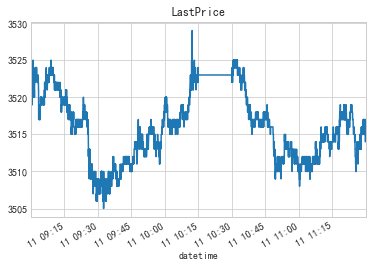

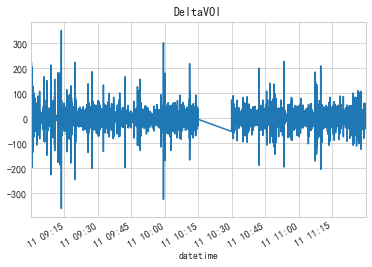

In [17]:
hc2001_df_one.VOI.plot()
plt.title('VOI')
plt.show()
hc2001_df_one.LastPrice.plot()
plt.title('LastPrice')
plt.show()
hc2001_df_one["DeltaVOI"].plot()
plt.title('DeltaVOI')
plt.show()

### VOI  检查自相关性(autocorrelation)


自相关（英语：Autocorrelation），也叫序列相关，是一个信号于其自身在不同时间点的互相关。非正式地来说，它就是两次观察之间的相似度对它们之间的时间差的函数。它是找出重复模式（如被噪声掩盖的周期信号），或识别隐含在信号谐波频率中消失的基频的数学工具。自相关函数在不同的领域，定义不完全等效。在某些领域，自相关函数等同于自协方差。


由于时间序列的相关性与之前的相同系列的值进行了计算，这被称为序列相关或自相关。一个时间序列的自相关系数被称为自相关函数，或简称ACF。这个图被称为相关图或自相关图。

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


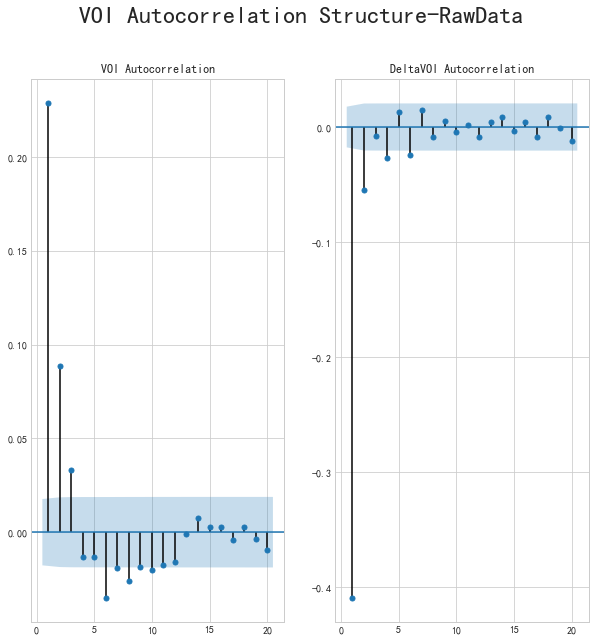

In [18]:
##ACF function for the returns at different frequencies
hc2001_df_one.dropna(inplace=True)

from statsmodels.graphics.tsaplots import plot_acf
plt.figure(1, figsize=(10,10))

ax1 = plt.subplot(121)
a=plot_acf(hc2001_df_one.VOI, ax = ax1, lags = np.arange(1,21), \
        title = 'VOI Autocorrelation')


ax2 = plt.subplot(122)
a=plot_acf(hc2001_df_one["DeltaVOI"], ax = ax2, lags = np.arange(1,21), \
        title = 'DeltaVOI Autocorrelation')

a=plt.suptitle('VOI Autocorrelation Structure-RawData', fontsize = 24)

plt.show()

图中 x 轴表示滞后值，y 轴上 -1 和 1 之间则表现了这些滞后值的正负相关性。

蓝色区域中的点表示统计学显着性。

Order imbalance has positive autocorrelation as presented in Figure 2.1. For most days, the order imbalance autocorrelation is signiﬁcant up to lag 15. Its ﬁrst di↵erence has a signiﬁcant lag-1 negative autocorrelation and is consistent with the results by Chordia [3]. This indicates that positive (negative) imbalances are often followed by periods of persistent positive (negative) imbalances due to traders splitting their orders across multiple periods as explained by Chordia [4].


订单不平衡具有正自相关，如图2.1所示。 在大多数情况下，阶次不平衡自相关最明显的是滞后15。其第一个差异具有显着的滞后1负自相关，并且与Chordia的结果一致[3]。 这表明正（负）失衡经常伴随着持续的正（负）失衡时期，这是由于交易员将其订单分割为多个时期所致，如Chordia所解释的[4]。

In [19]:
hc2001_df_one.VOI.describe()

count    12285.000000
mean        -0.265120
std         18.795341
min       -200.000000
25%         -3.000000
50%          0.000000
75%          3.000000
max        333.000000
Name: VOI, dtype: float64

In [20]:
100.*sum(hc2001_df_one.VOI == 0) / len(hc2001_df_one)

18.98249898249898

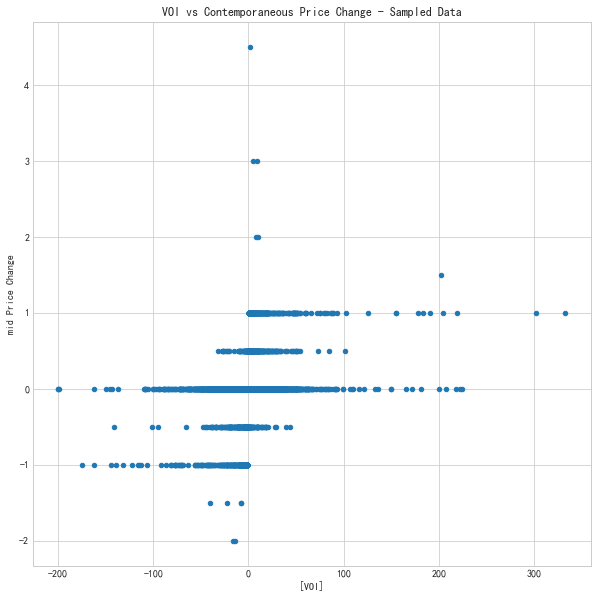

In [21]:
hc2001_df_one.plot(x = ['VOI'], y = ["dmid_price"], kind = 'scatter', grid = True, figsize = (10,10))

plt.ylabel('mid Price Change')
plt.title('VOI vs Contemporaneous Price Change - Sampled Data')

plt.show()

The relationship is evident here, a positive regression slope is strong suspect. Next we do the regression to see what is going on.

这种关系在这里很明显，正回归斜率很可疑。 接下来，我们进行回归以查看发生了什么。

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:             dmid_price   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1020.
Date:                Tue, 12 Nov 2019   Prob (F-statistic):          4.26e-215
Time:                        15:59:14   Log-Likelihood:                -337.34
No. Observations:               12285   AIC:                             678.7
Df Residuals:                   12283   BIC:                             693.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.305      0.7

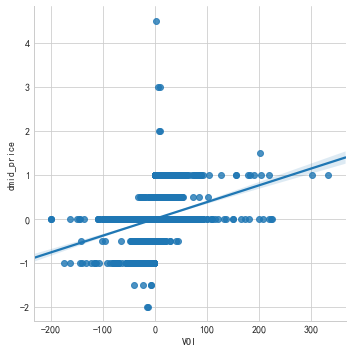

In [22]:
#Regression Analysis
import statsmodels.api as sm
import seaborn as sns

hc2001_df_one.dropna(inplace=True)
X = pd.DataFrame(hc2001_df_one["VOI"], index = hc2001_df_one.index)
X = sm.add_constant(X) ## add an intercept (beta_0) to our model
y = hc2001_df_one["dmid_price"] 

# Calibrate
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
print(model.summary())

#Plot the regression line as well alongside the data
import statsmodels.api as sm
sns.lmplot(x='VOI', y='dmid_price', data=hc2001_df_one, fit_reg=True)

Corresponds to Figure 2.2 of paper
R^2 observed here is almost similar to that observed in the paper. 


In [23]:
100.*sum(hc2001_df_one["dmid_price"] == 0)/len(hc2001_df_one)

89.79242979242979

Change in Mid Price is non-zero for only (100%-89%) = 11% of the cases

### ORI

Order Imbalance Ratio (OIR)

## VOI的一个缺点是
#### 它只考虑订单不平衡的大小而不考虑程度或强度
VOI仅衡量不平衡的程度，这不足以描述交易者在市场中的行为。 例如，如果当前的出价更改量为300且当前的询价变化量为200，则VOI为100，这被认为是一个强烈的购买信号。 然而，这并未考虑出价量和询价量之间的比率，这表示市场中潜在买家的"实力"。 
#### 因此，我们定义了一个称为订单失衡率（OIR）的新因子，如下：

The VOI only measures the magnitude of the imbalance which is not sufficient to describe the behaviour of the traders in the market. For example, if the current bid change volume is 300 and the current ask change volume is 200, the VOI is 100, which is considered a strong signal to buy. However, this does not take into consideration the ratio between the bid volume and ask volume which indicates the strength of the potential buyers in the market. 
#### Hence, we define a new factor called the Order Imbalance Ratio (OIR), as:

$$
ORI_t=\frac{V^B_t - V^A_t} {V^B_t + V^A_t}
$$


该因素通过允许我们区分差异较大但比率较小的情况来补充体积订单不平衡。 在上面给出的例子中，OIR只有0.2，表明购买的原始信号可能不会那么强

This factor complements the volume order imbalance by allowing us to distinguish cases where the difference is large but the ratio is small. In the example presented above, the OIR is only 0.2, indicating that the original signal to buy may not be that strong after all

根据定义，大的OIR意味着Bid量远大于给定时间的Ask量，表明许多交易者有意购买，很少有人有意出售。 但由于大的OIR与负价格变化相关，这意味着当价格下跌时，更多的交易者愿意购买。 该结果证明了订单如何随时间分割，而不是仅表示存在订单分割的自相关。

By definition, a large OIR means that the bid volume is much greater than the ask volume at a given time, indicating many traders have the intention to buy, and very few have the intention to sell. But since a large OIR is associated with a negative price change, it means that more a larger proportion of traders are willing to buy when prices have fallen. This result demonstrate how the orders are split over time as opposed to the autocorrelations which only indicates the presence of order-splitting.



In [24]:
# 计算 OIR
hc2001_df_one["OIR"] = (hc2001_df_one['BidVolume1'] - hc2001_df_one['AskVolume1']) / (hc2001_df_one['BidVolume1'] + hc2001_df_one['AskVolume1'])
hc2001_df_one['DeltaOIR'] = hc2001_df_one['OIR'].diff()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


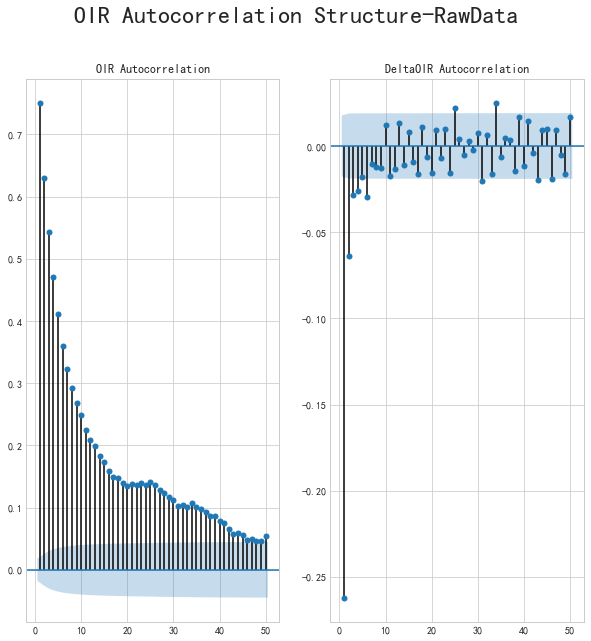

In [25]:
##ACF function for the OIR-RawData
hc2001_df_one.dropna(inplace=True)
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(1, figsize=(10,10))

ax1 = plt.subplot(121)
a=plot_acf(hc2001_df_one["OIR"], ax = ax1, lags = np.arange(1,51), \
        title = 'OIR Autocorrelation')


ax2 = plt.subplot(122)
a=plot_acf(hc2001_df_one["DeltaOIR"], ax = ax2, lags = np.arange(1,51), \
        title = 'DeltaOIR Autocorrelation')

a=plt.suptitle('OIR Autocorrelation Structure-RawData', fontsize = 24)

plt.show()

Next we have to check whether the Rt process is stationary- we perform the same check as has been performed in the paper (Fig 3.2)

### 成交均价
#### $M_t$ 是在t时刻的中间价 the mid-price at time t 的意思.
#### 使用数据集中的交易量和营业额信息，我们能够确定两个时间步之间的平均交易价格。我们定义平均交易价格 $\overline{TP_t}$，

$$
MP_t=\frac{P^A_t+P^B_t}{2}
$$

$$
\overline{TP_t}=
\begin{cases}
M_1,&t=1 \\ 
\frac{1}{contract\_multiplier}\frac{T_t-T_{t-1}}{V_t-V_{t-1}} ,&V_t<>V_{t-1} \\
\overline{TP_{t-1}},&V_t=V_{t-1}
\end{cases}
$$

### 中价均值回归

除了VOI和OIR之外，我们还包括一种将交易分类为买方启动或卖方启动的方法。

where $T_t$ is the turnover (trade volume in CNY) and $V_t$ is the transaction volume at time t. This process represents the average price that other market participants executed their trades at which can be interpreted as a proxy for trade imbalance. 

这个过程代表了其他市场参与者执行交易的平均价格，可以将其解释为贸易不平衡的代理。

 By checking whether $\overline{TP}$ is closer to the ask (bid) price, we can classify trades as being more buyer (seller) initiated. However, instead of a binary classification, we define the factor as the distance of the average trade price from the average mid-price over the time-step (t − 1, t]:

通过检查$\overline{TP}$ 是否更接近Ask（Bid），我们可以将交易分类为更多买方Buy（卖方Sell）发起。 然而，我们将该因子定义为平均交易价格与时间步长（t-1，t）之间的平均中间价格的距离，而不是二元分类：

$$
R_t = \overline{TP_t}-\overline{MP_t}
$$

因素Rt，我们称之为中间价格基础（MPB），是价格变化的重要预测因素，因为它的均值反转属性。 它给出了交易是买方还是卖方的持续分类。 

### 大量正（负）数量意味着交易平均而言更接近要价（买入价）。 

我们对MPB的定义类似于[3,4,11]中使用的订单不平衡定义的定义，其中他们使用Lee和Ready算法[9]将交易分类为买方或卖方发起的。

The factor Rt , which we call the mid-price basis (MPB), is an important predictor of price change because of its mean reversive
properties. It gives a continuous classification of whether trades were buyer or seller initiated. A large positive (negative) quantity means the trades were, on average,
closer to the ask (bid) price. Our definition of the MPB is similar to the definition of order imbalance definition used in [3, 4, 11] where they use the Lee and Ready algorithm [9] to classify trades as buyer or seller initiated.

为了检查过程Rt是否是均值回归，我们应用[2]中概述的方差比（VR）测试。 对于时间序列Rt =φRt-1 +εt，VR检验的零假设是H0：φ= 1.如果序列是随机游走（φ= 1），那么对于k周期滞后，我们得到 关系：


To check whether the process Rt is mean-reverting, we apply the variance ratio (VR) test outlined in [2]. For the time series Rt = φRt−1 + εt , the null hypothesis of the VR test is H0 : φ = 1. If the series is a random walk (φ = 1), then for a k-period lag, we get the relationship:


$$
R_t-R_{t-k} = (R_t-R_{t-1})+ (R_{t-1}-R_{t-2})+ .... + (R_{t-k+1}-R_{t-k}) \\
=E_t+E_{t-1}+....+E_{t-k+1}
$$

Assuming that the errors are independent and identically normally distributed with zero mean and constant variance, taking the variance of both sides gives:
 In this paper, we will not address the issue of a finite sample size as our daily sample size (around 30,000) is likely considered large enough for a variance ratio test of up to lag 20. Figure 3.2 below depicts the ratios for k = 2 to 100 and indicate that they are below 1 for all lags, meaning the process Rt exhibits mean-reversion [2]. The result is statistically significant at the 99% confidence level.
We expect that Rt will revert back to mean 0 so if Rt > 0, the mid-price will eventually increase and revert towards the average trade price and if Rt < 0, then we would expect the mid-price to decrease back to average trade price. Thus, we have a buy signal when Rt > 0 and sell signal when Rt < 0. The positive relationship between Rt (MPB) and the average mid-price change (response) is shown below in Figure 3.3.

假设误差是独立的且相同的正态分布，零均值和常数方差，则取两边的方差给出：
在本文中，我们不会解决有限样本的问题因为我们的每日样本量（大约30,000）的大小可能被认为足够大，方差比测试可达到滞后20.下面的图3.2描述了k = 2到100的比率，并表明它们对于所有滞后都低于1，意思是 过程Rt表现出均值回归[2]。 结果在99％置信水平下具有统计学意义。
我们预计Rt将恢复到平均0，因此如果Rt > 0，中间价格最终会增加并恢复到平均交易价格，如果Rt < 0，那么我们预计中间价格将回落至平均交易价钱。 
因此，当Rt > 0时我们有买入信号，当Rt < 0时卖出信号.Rt（MPB）与平均中间价格变化（响应）之间的正相关关系如下图3.3所示。

In [26]:
contract_multiplier = 10

# 计算成交均价

hc2001_df_one["dVol"] = hc2001_df_one['Volume'].diff()
hc2001_df_one["dTO"] = hc2001_df_one['Turnover'].diff()

# 有可能两次tick之间没有成交量，dVol 为0， 后面计算均价会出现 除零 错误, 产生 inf 。
hc2001_df_one=hc2001_df_one[hc2001_df_one['dVol'] > 0]

hc2001_df_one["AvgTrade_price"] = hc2001_df_one["dTO"] / hc2001_df_one["dVol"] / contract_multiplier
hc2001_df_one["AvgTrade_price"] = hc2001_df_one["AvgTrade_price"].fillna(method='ffill').fillna(method='bfill')
rolling_mean = hc2001_df_one["mid_price"].rolling(center=False, window=2).mean()
rolling_mean.iloc[0] = hc2001_df_one["mid_price"].iloc[0]
# 计算 Rt  Page_19
#  The factor Rt, which we call the mid-price basis (MPB)
hc2001_df_one["MPB"] = hc2001_df_one["AvgTrade_price"] - rolling_mean


hc2001_df_one.dropna(inplace=True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


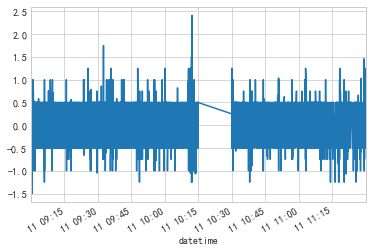

In [27]:
hc2001_df_one["MPB"].plot()
plt.show()

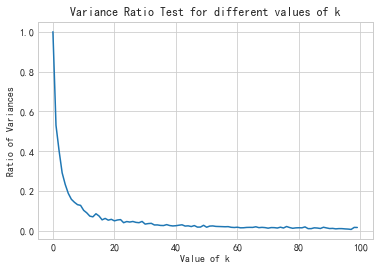

In [28]:
import matplotlib.pyplot as plt
ratio = []
for i in range(1,101):
    # 方差var
    num = np.var(hc2001_df_one["MPB"].iloc[::i].diff().dropna().tolist())
    den =i*np.var(hc2001_df_one["MPB"].iloc[::1].diff().dropna().tolist())
    ratio.append(num/den)

plt.plot(ratio)
plt.title('Variance Ratio Test for different values of k')
plt.ylabel('Ratio of Variances')
plt.xlabel('Value of k')
plt.show()

Declining values of ratio test confirm the fact that the proces Rt is mean reverting

### 我们想预测20 个周期以后的均价，减去当前价。 相当于预测20个周期（tick为500ms）以后的价格变动

In [29]:
test_period= 20
#之后20 个tick的平均价格
hc2001_df_one['AveragePriceChange'] = hc2001_df_one['mid_price'].rolling(test_period).mean().shift(-test_period) - hc2001_df_one['mid_price']

hc2001_df_one.dropna(inplace=True)


### 打印一下数据看看

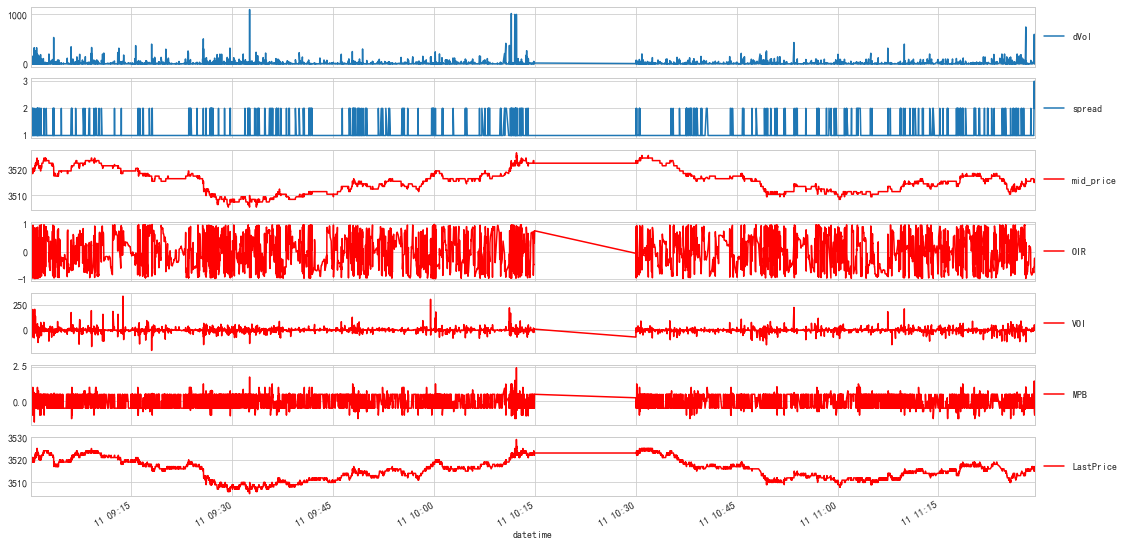

In [30]:
fig, ax = plt.subplots(7, 1, figsize=(18, 10), sharex=True)

hc2001_df_one["dVol"].plot(ax=ax[0], ls='-', label='dVol')
#ax[0].axhline(y=2.0, c="r", ls="--", lw=2)
ax[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one["spread"].plot(ax=ax[1], ls='-', label='spread')
ax[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one["mid_price"].plot(ax=ax[2], ls='-', color='r',label='mid_price')
ax[2].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one["OIR"].plot(ax=ax[3], ls='-', color='r',label='OIR')
ax[3].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one["VOI"].plot(ax=ax[4], ls='-', color='r',label='VOI')
ax[4].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one["MPB"].plot(ax=ax[5], ls='-', color='r',label='MPB')
ax[5].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one["LastPrice"].plot(ax=ax[6], ls='-', color='r',label='LastPrice')
ax[6].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

plt.show()

### 挑选部分数据

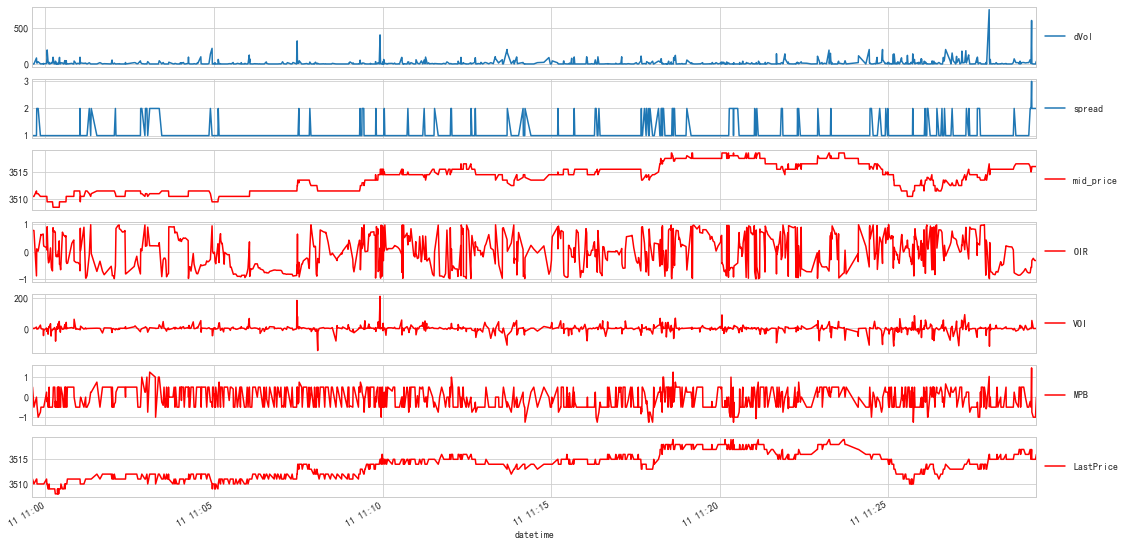

In [31]:
display_length = -1000

fig, ax = plt.subplots(7, 1, figsize=(18, 10), sharex=True)

hc2001_df_one[display_length:]["dVol"].plot(ax=ax[0], ls='-', label='dVol')
#ax[0].axhline(y=2.0, c="r", ls="--", lw=2)
ax[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one[display_length:]["spread"].plot(ax=ax[1], ls='-', label='spread')
ax[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one[display_length:]["mid_price"].plot(ax=ax[2], ls='-', color='r',label='mid_price')
ax[2].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one[display_length:]["OIR"].plot(ax=ax[3], ls='-', color='r',label='OIR')
ax[3].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one[display_length:]["VOI"].plot(ax=ax[4], ls='-', color='r',label='VOI')
ax[4].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one[display_length:]["MPB"].plot(ax=ax[5], ls='-', color='r',label='MPB')
ax[5].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

hc2001_df_one[display_length:]["LastPrice"].plot(ax=ax[6], ls='-', color='r',label='LastPrice')
ax[6].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

plt.show()

### 简单线性模型 y = ax+b，只用MPB作为参数

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:     AveragePriceChange   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     46.98
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           8.10e-12
Time:                        15:59:27   Log-Likelihood:                -5595.4
No. Observations:                4801   AIC:                         1.119e+04
Df Residuals:                    4799   BIC:                         1.121e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.011      0.047      0.9

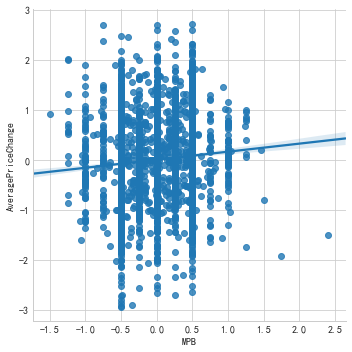

In [32]:

#Regression Analysis

X = pd.DataFrame(hc2001_df_one["MPB"], index = hc2001_df_one.index)
X = sm.add_constant(X) ## add an intercept (beta_0) to our model
y = hc2001_df_one["AveragePriceChange"]

# Calibrate
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)
y_fitted = model.fittedvalues
# Print out the statistics
print(model.summary())
print(model.params)

#Plot the regression line as well alongside the data
sns.lmplot(x='MPB',y='AveragePriceChange',data=hc2001_df_one, fit_reg=True) 

请注意以下内容：

Dep. Variable 指出哪个变量是模型的响应。

Model 是拟合中使用的模型，在本案例中是 OLS。

另外，Method 指出模型参数是如何被计算的。在本案例中被设置为 Least Squares。

目前为止，还没有出现任何新的信息，这些都已经在上述代码中设置了。然而，也有另一些令人感兴趣的项，比如：

观测量的数目（No. Observations）。

残差的自由度（DF Residuals）

DF Model 指模型参数的数目，注意它并不包括代码中定义的 X 的常数项。

这基本上是左边栏的内容。右边栏给出了更多关于拟合的信息。例如你可以看到：
<font color="red">
R-squared 是决定系数。这个分数表明回归线接近真实数据点的程度。在本例中，结果是 0.014，用百分比表示该分数是 1.4% 。当决定系数是 0% 时，表明模型完全不能解释响应数据在其均值附近的变异性。当然，当分数为 100% 时情况恰恰相反。
</font>

Adj. R-squared 分数乍看上去和 R-squared 的数值差不多。然而，该度量背后的计算是基于观测量的数目和残差的自由度调整了 R-squared 的值。在本例中这一调整没有起到多少作用，致使两者的结果相近。

F-statistic 衡量该拟合的显著性。通过将模型的均方误差除以残差的均方误差来计算。

Prob (F-statistic) 指得到上述 F-statistic 结果的概率，假设零假设认为它们是无关的。

Log-Likelihood 指的是似然函数的对数。

AIC 是赤池信息量准则，这一指标根据观测量的数目和模型的复杂性，对对数似然度进行了调整。

最后，BIC 或者是贝叶斯信息准则，类似于上述 AIC，但是它用更多的参数更严格地惩罚模型。

在模型摘要的第一部分下方，汇报了模型的每一项系数：

coef 表示系数的估计值。

std err 是系数估计的标准误差。

t 代表t统计量。该度量用于测量系数的统计显著性。

P>|t| 表示系数等于0为真的零假设。如果该值小于置信水平（通常是0.05），则表明该系数对应的项和响应之间存在统计学上的显著关系。

最后，在模型摘要的最后部分，你将看到用于评估残差分布的其他统计检验：

Omnibus 是  Omnibus D’Angostino 检验，它为偏斜和峰度的存在提供了组合的统计检验。

Prob(Omnibus) 将 Omnibus 度量转变成了概率。

其次，Skew 或偏斜，测量数据关于均值的对称性。

Kurtosis 给出了分布形状的指示，因为它比较了接近均值的数据量和远离均值（在尾部）的数据量。

Durbin-Watson 是对自相关的存在的检验，Jarque-Bera (JB) 是另一项对偏斜和峰度（kurtosis）的检验。也可以将其结果转换成概率，即为Prob (JB)。

最后，Cond. No 是对多重共线性的检验。


### 注意我们得到的 R-squared: 0.014, 说明没有学会有效的拟合参数

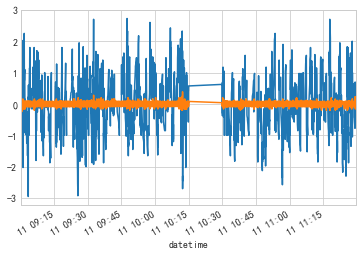

In [33]:
hc2001_df_one["AveragePriceChange"].plot()
y_fitted.plot()
plt.show()

[Figure 3.3] Though it's difficult to spot here, the regression points to a significant positive relationship between the average price change over the next specified(20) periods

尽管很难在这里发现，但回归表明在接下来的指定（20）期间内平均价格变化之间存在显着的正相关关系

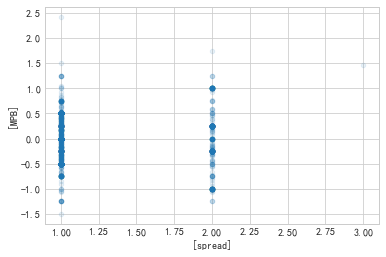

In [34]:
#Plot the relationships with the bid-ask spread

hc2001_df_one.plot(x=['spread'], y=['MPB'], kind='scatter', alpha = 0.1)

[Figure 3.4] Can't say much based on this relationship

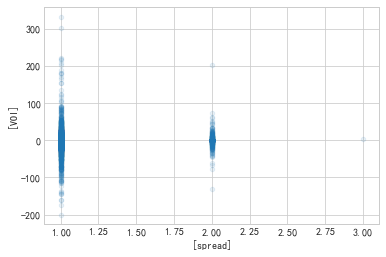

In [35]:
hc2001_df_one.plot(x=['spread'], y=['VOI'], kind='scatter', alpha = 0.1)

From Figure 3.4 above, we see that when spread is large, there are very few observations where the average change in mid-price is away from zero. Hence when liquidity is low, the price is slow to change and therefore trading may be unfavourable. This will potentially reduce the risk of trading on a weak signal when the spread is large. One interesting observation is that a large VOI (negative or positive) is associated with smaller spreads. From Figure 3.5 below, we notice that large spreads only occur when order imbalance is near 0. Chordia [3] ﬁnds that higher spreads are associated with a larger (absolute) order imbalance but our ﬁndings above does not agree with his results. This may be due to the fact that we are using high frequency data and not aggregated daily data.

Using these relationships between spread and price change and spread and order imbalance, we adjust our factors so that we would not falsely obtain a trading signal when spread is large. The ﬁnal parametrized model which includes the spread adjustment is presented in the following section.


从上面的图3.4中我们可以看到，当价差很大时，几乎没有观察到中间价格的平均变化远离零。 因此，当流动性较低时，价格变化缓慢，因此交易可能不利。 当价差较大时，这将有可能降低以弱信号进行交易的风险。 一个有趣的发现是，较大的VOI（负或正）与较小的价差相关。 从下面的图3.5中，我们注意到只有在订单不平衡接近于0时才会出现大的价差。Chordia[3]发现价差较高与较大的（绝对）订单不平衡有关，但是上面的发现与他的结果不一致。 这可能是由于我们使用的是高频数据，而不是汇总的每日数据。

利用价差和价格变化以及价差和订单不平衡之间的这些关系，我们调整了因素，以使价差大时不会错误地获得交易信号。 下一节介绍了最终的参数化模型，其中包括价差调整。

In [36]:
delay = 20
lags = 5


In [37]:
#Run the final Regression model on which trading is based on
hc2001_df_one['VOI0'] = hc2001_df_one['VOI']/hc2001_df_one['spread']
hc2001_df_one['OIR0'] = hc2001_df_one['OIR']/hc2001_df_one['spread']
hc2001_df_one['R0']   = hc2001_df_one['MPB']/hc2001_df_one['spread']
VOIFeatureList = ['VOI0']
OIRFeatureList = ['OIR0']
for i in range(1,lags + 1):
    VOIString = 'VOI' + str(i)
    OIRString = 'OIR' + str(i)
    VOIFeatureList.append(VOIString)
    OIRFeatureList.append(OIRString)
    hc2001_df_one[VOIString] = hc2001_df_one['VOI'].shift(i)/hc2001_df_one['spread']
    hc2001_df_one[OIRString] = hc2001_df_one['OIR'].shift(i)/hc2001_df_one['spread']

#Run the regression now
#Regression Analysis
featureList = VOIFeatureList
featureList.extend(OIRFeatureList)
featureList.append('R0')

print(featureList)

['VOI0', 'VOI1', 'VOI2', 'VOI3', 'VOI4', 'VOI5', 'OIR0', 'OIR1', 'OIR2', 'OIR3', 'OIR4', 'OIR5', 'R0']


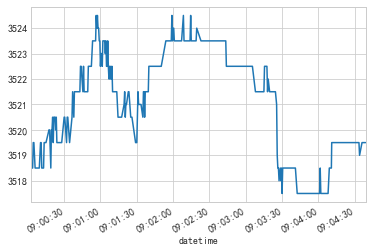

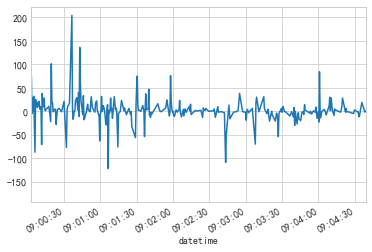

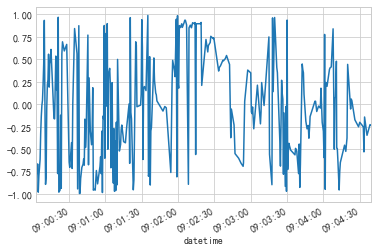

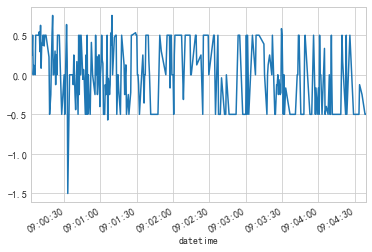

In [38]:
hc2001_df_one[1:300]['mid_price'].plot()
plt.show()
hc2001_df_one[1:300]['VOI0'].plot()
plt.show()
hc2001_df_one[1:300]['OIR0'].plot()
plt.show()
hc2001_df_one[1:300]['R0'].plot()
plt.show()


### 使用更多参数试试，使用['VOI0', 'VOI1', 'VOI2', 'VOI3', 'VOI4', 'VOI5', 'OIR0', 'OIR1', 'OIR2', 'OIR3', 'OIR4', 'OIR5', 'R0']

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:     AveragePriceChange   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     26.61
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           1.48e-63
Time:                        15:59:31   Log-Likelihood:                -5447.2
No. Observations:                4796   AIC:                         1.092e+04
Df Residuals:                    4782   BIC:                         1.101e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.011     -0.215      0.8

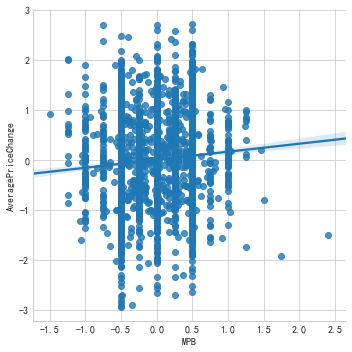

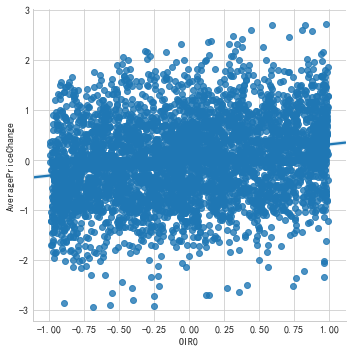

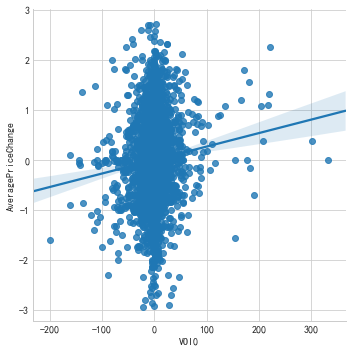

In [39]:
hc2001_df_one.dropna(inplace=True)

X = hc2001_df_one[featureList]
X = sm.add_constant(X) ## add an intercept (beta_0) to our model
y = hc2001_df_one["AveragePriceChange"] 

# Calibrate
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)
y_fitted = model.fittedvalues

# Print out the statistics
print(model.summary())
print(model.params)

#Plot the regression line as well alongside the data
sns.lmplot(x='MPB',y='AveragePriceChange',data=hc2001_df_one, fit_reg=True) 

sns.lmplot(x='OIR0',y='AveragePriceChange',data=hc2001_df_one, fit_reg=True) 

sns.lmplot(x='VOI0',y='AveragePriceChange',data=hc2001_df_one, fit_reg=True) 


### 这次结果 R-squared:0.089  稍有改善

Similar to the previous results in Table 2.1, the instantaneous and lag-1 VOI remain signiﬁcant positive factors as indicated by the blue cells. Furthermore, the new order imbalance ratio factors are also signiﬁcant at least half the time up to lag-2. More interestingly, the instantaneous order imbalance ratio has a positive relationship with price change while the lag-1 and lag-2 OIR have a negative relationship. Using this deﬁnition of order imbalance, these coecients are consistent with the ﬁndings in Chordia [4]. Evidence of the price pressure (induced by the instantaneous OIR) reversal by the lag-1 OIR coecient is very pronounced as they were negative and signiﬁcant for every trading day. 

与表2.1中的先前结果相似，瞬时和lag-1 VOI仍然是重要的正因子，如蓝色细胞所示。 此外，新阶不平衡比率因子在滞后2之前至少有一半的时间也很重要。 更有趣的是，瞬时订单不平衡率与价格变化呈正相关，而滞后1和滞后2 OIR具有负关系。 利用这种秩序失衡的定义，这些经济学家与乔迪亚[4]中的发现是一致的。 滞后1的OIR系数逆转的价格压力（由瞬时OIR引起）的证据非常明显，因为它们在每个交易日都是负值且意义重大。

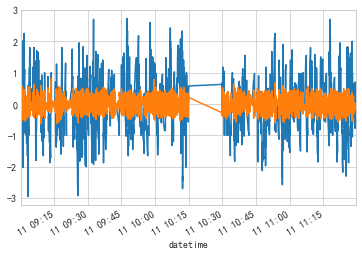

In [40]:
hc2001_df_one["AveragePriceChange"].plot()
y_fitted.plot()
plt.show()

In [41]:
residuals = hc2001_df_one["AveragePriceChange"] -  predictions
residuals

datetime
2019-09-11 09:00:04.555   -0.434562
2019-09-11 09:00:05.065   -0.572595
2019-09-11 09:00:06.080    0.745918
2019-09-11 09:00:06.563    0.355704
2019-09-11 09:00:07.061    0.410076
2019-09-11 09:00:07.546    0.429390
2019-09-11 09:00:08.045    0.610205
2019-09-11 09:00:08.552    0.600029
2019-09-11 09:00:09.058    0.696579
2019-09-11 09:00:09.547    0.629905
2019-09-11 09:00:10.087    0.552341
2019-09-11 09:00:10.574    0.429309
2019-09-11 09:00:11.055    0.336795
2019-09-11 09:00:11.567    1.205029
2019-09-11 09:00:12.068    0.991352
2019-09-11 09:00:12.563    1.058085
2019-09-11 09:00:13.063    1.008790
2019-09-11 09:00:13.559    0.268850
2019-09-11 09:00:14.060    0.219879
2019-09-11 09:00:14.548    0.320090
2019-09-11 09:00:15.061    0.333256
2019-09-11 09:00:17.546    0.040001
2019-09-11 09:00:18.057    0.096751
2019-09-11 09:00:19.050    1.502195
2019-09-11 09:00:19.550   -0.043385
2019-09-11 09:00:20.045    0.120007
2019-09-11 09:00:20.570    0.072833
2019-09-11 09:00:21

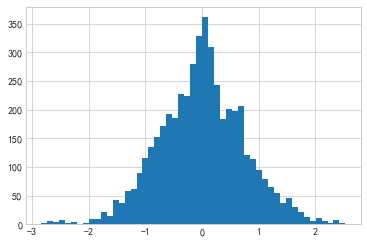

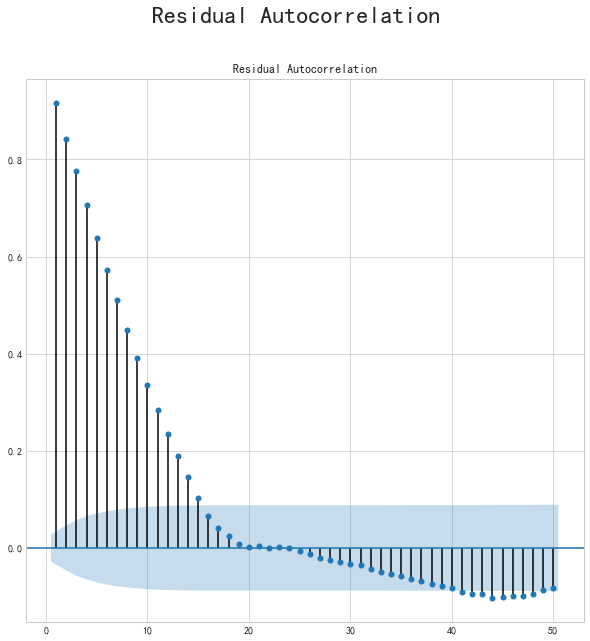

In [42]:
residuals = hc2001_df_one["AveragePriceChange"] -  predictions
residuals.hist(bins=51)
plt.show()
##ACF function for the OIR-ResampledData
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(1, figsize=(10,10))

ax1 = plt.subplot(111)
a=plot_acf(residuals, ax = ax1, lags = np.arange(1,51), \
        title = 'Residual Autocorrelation')

a=plt.suptitle('Residual Autocorrelation', fontsize = 24)

plt.show()

### 将数据分为2部分，前一个部分用来做拟合，后面用来做测试

In [43]:
#Try to simulate a trading run 
train_set  = hc2001_df_one.iloc[:int(len(hc2001_df_one)/2)]
test_set = hc2001_df_one.iloc[int(len(hc2001_df_one)/2):]

#The idea is to train the model on the inSample and then use the model to trade on the outSample
X_train = train_set[featureList]
X_train = sm.add_constant(X_train) ## add an intercept (beta_0) to our model
y_train = train_set["AveragePriceChange"]

# Calibrate
model = sm.OLS(y_train, X_train).fit() ## sm.OLS(output, input)
predictions = model.predict(X_train)
y_fitted = model.fittedvalues
# Print out the statistics
model.summary()

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     AveragePriceChange   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     10.17
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           3.41e-21
Time:                        15:59:38   Log-Likelihood:                -2824.9
No. Observations:                2398   AIC:                             5678.
Df Residuals:                    2384   BIC:                             5759.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.016     -0.022      0.982      -0.032       0.031
VOI0           0.0018      0.001      2.512      0.012       0.000       0.003
VOI1       -1.774e-05      0.001     -0.026      0.980      -0.001       0.001
VOI2          -0.0002      0.001     -0.334      0.738      -0.002       0.001
VOI3          -0.0003      0.001     -0.401      0.689      -0.002       0.001
VOI4        9.126e-05      0.001      0.136      0.892      -0.001       0.001
VOI5           0.0003      0.001      0.486      0.627      -0.001       0.002
OIR0           0.3495      0.035      9.846      0.000       0.280       0.419
OIR1          -0.1045      0.039     -2.660      0.008      -0.182      -0.027
OIR2          -0.0568      0.040     -1.418      0.156      -0.135       0.022
OIR3          -0.0107      0.040     -0.267      0.789      -0.090       0.068
OIR4          -0.0120      0.040     -0.303      0.762      -0.090       0.066
OIR5          -0.0311      0.037     -0.850      0.395      -0.103       0.041
R0             0.0914      0.038      2.418      0.016       0.017       0.166
==============================================================================
Omnibus:                       15.829   Durbin-Watson:                   0.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.679
Skew:                          -0.085   Prob(JB):                     3.23e-05
Kurtosis:                       3.422   Cond. No.                         78.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

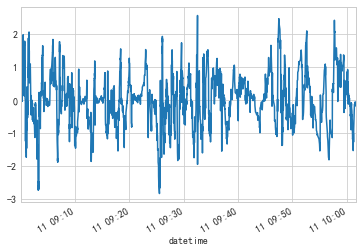

In [44]:
(train_set["AveragePriceChange"] -  y_fitted).plot()
plt.show()

### 拟合的不美好

In [45]:
#Predictions on outSampledData
#The idea is to train the model on the inSample and then use the model to trade on the outSample
X_test = test_set[featureList]
X_test = sm.add_constant(X_test) ## add an intercept (beta_0) to our model
#Get the predictions
predictions = model.predict(X_test)
y_fitted = model.fittedvalues



C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


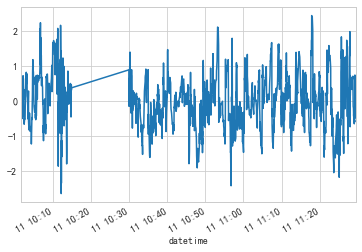

In [46]:
(test_set["AveragePriceChange"] -  predictions).plot()
plt.show()

### 预测效果并不是非常好，使用更多天的数据做一下拟合

In [47]:
# 批量制作特征的函数

def get_bid_cv(bv, sbv, dbp):
    if dbp == 0:
        return bv - sbv
    elif dbp < 0:
        return 0
    else:
        return bv


def get_ask_cv(av, sav, dap):
    if dap == 0:
        return av - sav
    elif dap < 0:
        return av
    else:
        return 0

    
def mak_OrderImbalance_feature(df_one, contract_multiplier = 10, test_period= 20):
    df_one["spread"] = df_one["AskPrice1"] - df_one["BidPrice1"]
    df_one["mid_price"] = (df_one['BidPrice1'] + df_one['AskPrice1']) / 2
    df_one["dmid_price"] = df_one["mid_price"].diff()

    #之后20 个tick的平均价格
    df_one['AveragePriceChange'] = df_one['mid_price'].rolling(test_period).mean().shift(-test_period) - df_one['mid_price']

        
    df_one["dBid_price"] = df_one['BidPrice1'].diff()
    df_one["dAsk_price"] = df_one['AskPrice1'].diff()

    df = pd.concat(
        [df_one['BidVolume1'], df_one['BidVolume1'].shift(1).fillna(0), df_one["dBid_price"]],
        axis=1)
    df.columns = ['bv', 'sbv', 'dbp']

    df['bid_CV'] = df.apply(lambda row: get_bid_cv(row['bv'], row['sbv'], row['dbp']), axis=1)
    df_one["bid_CV"] = df['bid_CV']

    # 为了方便在同一个row里面计算而组装
    df = pd.concat(
        [df_one['AskVolume1'], df_one['AskVolume1'].shift(1).fillna(0), df_one["dAsk_price"]],
        axis=1)
    df.columns = ['av', 'sav', 'dap']

    df['ask_CV'] = df.apply(lambda row: get_ask_cv(row['av'], row['sav'], row['dap']), axis=1)
    df_one["ask_CV"] = df['ask_CV']
    df_one["VOI"] = df_one["bid_CV"] - df_one["ask_CV"]
    df_one['DeltaVOI'] = df_one.VOI.diff()

    df_one.dropna(inplace=True)

    # 计算 OIR
    df_one["OIR"] = (df_one['BidVolume1'] - df_one['AskVolume1']) / (
                df_one['BidVolume1'] + df_one['AskVolume1'])
    df_one['DeltaOIR'] = df_one['OIR'].diff()
    
    df_one.dropna(inplace=True)

    # 计算成交均价
    df_one["dVol"] = df_one['Volume'].diff()
    # 有可能两次tick之间没有成交量，dVol 为0， 后面计算均价会出现 除零 错误, 产生 inf 。
    df_one = df_one[df_one['dVol'] > 0]

    df_one["dTO"] = df_one['Turnover'].diff()

    df_one["AvgTrade_price"] = df_one["dTO"] / df_one["dVol"] / contract_multiplier
    df_one["AvgTrade_price"] = df_one["AvgTrade_price"].fillna(method='ffill').fillna(method='bfill')
    rolling_mean = df_one["mid_price"].rolling(center=False, window=2).mean()
    rolling_mean.iloc[0] = df_one["mid_price"].iloc[0]
    # 计算 Rt  Page_19
    #  The factor Rt, which we call the mid-price basis (MPB)
    df_one["MPB"] = df_one["AvgTrade_price"] - rolling_mean

    df_one.dropna(inplace=True)

    # In[319]:

    # Run the final Regression model on which trading is based on
    df_one['VOI0'] = df_one['VOI'] / df_one['spread']
    df_one['OIR0'] = df_one['OIR'] / df_one['spread']
    df_one['R0'] = df_one['MPB'] / df_one['spread']

    for i in range(1, lags + 1):
        VOIString = 'VOI' + str(i)
        OIRString = 'OIR' + str(i)

        df_one[VOIString] = df_one['VOI'].shift(i) / df_one['spread']
        df_one[OIRString] = df_one['OIR'].shift(i) / df_one['spread']


    df_one.dropna(inplace=True)

    return df_one


In [48]:
hc2001_df.tail(3)

,logtime,InstrumentID,LastPrice,Volume,Turnover,OpenInterest,BidPrice1,BidVolume1,AskPrice1,AskVolume1,TradingDay,UpdateTime,UpdateMillisec,date_phase,SecondOfDay,date_time_phase
datetime,,,,,,,,,,,,,,,,
2019-09-11 22:59:58.630,20190911225958630,hc2001,3508.0,70432,2.473837e+09,526504.0,3508.0,6,3509.0,8,20190912,22:59:58,500,20190911,82798,3
2019-09-11 22:59:59.130,20190911225959130,hc2001,3508.0,70446,2.474328e+09,526510.0,3507.0,33,3508.0,4,20190912,22:59:59,0,20190911,82799,3
2019-09-11 22:59:59.630,20190911225959630,hc2001,3508.0,70454,2.474608e+09,526510.0,3508.0,2,3509.0,7,20190912,22:59:59,500,20190911,82799,3


### 多次训练数据，参考

https://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html

In [49]:
count = 3
i = 0
tick_date_phase = hc2001_df.groupby(hc2001_df["date_phase"])

tick_data_all = None
for df_phase_date, df_phase_date_ticks in tick_date_phase:
    #print(df_phase_date, df_phase_date_ticks)
    df_phase_date_ticks_cp = df_phase_date_ticks#.copy()
    tick_df1_date_time_phase = df_phase_date_ticks_cp.groupby(df_phase_date_ticks_cp["date_time_phase"])
    for df_phase_date_time, df_phase_date_time_ticks in tick_df1_date_time_phase:
        #print("df_phase_date_time,", df_phase_date_time,",df_phase_date_time_ticks: \n",df_phase_date_time_ticks[:1])
        #todo 本来应该是循环，此处仅适用最后一个时间段
        

        tick_df1_one = mak_OrderImbalance_feature(df_phase_date_time_ticks)
        print(len(tick_df1_one))
        if i == 0:
            tick_data_all = tick_df1_one
        else:
            tick_data_all = pd.concat([tick_data_all,tick_df1_one])
        i = i+1
        if i > count:
            break
        



test_set = hc2001_df[ (hc2001_df["date_time_phase"] == 3) & (hc2001_df["date_phase"] == 20190911) ]
test_set = mak_OrderImbalance_feature(test_set)

X_test = test_set[featureList]
y_test = test_set["AveragePriceChange"]

tick_data_all

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib

4288
4808
4896
3830


,logtime,InstrumentID,LastPrice,Volume,Turnover,OpenInterest,BidPrice1,BidVolume1,AskPrice1,AskVolume1,TradingDay,UpdateTime,UpdateMillisec,date_phase,SecondOfDay,date_time_phase,spread,mid_price,dmid_price,AveragePriceChange,dBid_price,dAsk_price,bid_CV,ask_CV,VOI,DeltaVOI,OIR,DeltaOIR,dVol,dTO,AvgTrade_price,MPB,VOI0,OIR0,R0,VOI1,OIR1,VOI2,OIR2,VOI3,OIR3,VOI4,OIR4,VOI5,OIR5
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-10 21:00:05.098,20190910210005098,hc2001,3518.0,1916,6.745856e+07,522226.0,3517.0,28,3520.0,19,20190911,21:00:05,0,20190910,75605,3,3.0,3518.5,-0.5,-0.625,-1.0,0.0,0.0,-18.0,18.0,19.0,0.191489,0.733156,82.0,2885520.0,3518.926829,0.176829,6.0,0.063830,0.058943,-0.333333,-0.180556,0.333333,-0.308642,8.333333,0.286822,-5.0,0.177083,-2.333333,0.100000
2019-09-10 21:00:05.579,20190910210005579,hc2001,3520.0,2020,7.111844e+07,522184.0,3518.0,10,3520.0,8,20190911,21:00:05,500,20190910,75605,3,2.0,3519.0,0.5,-1.250,1.0,0.0,10.0,-11.0,21.0,3.0,0.111111,-0.080378,104.0,3659880.0,3519.115385,0.365385,10.5,0.055556,0.182692,9.000000,0.095745,-0.500000,-0.270833,0.500000,-0.462963,12.5,0.430233,-7.500000,0.265625
2019-09-10 21:00:06.085,20190910210006085,hc2001,3518.0,2054,7.231464e+07,522180.0,3518.0,36,3520.0,16,20190911,21:00:06,0,20190910,75606,3,2.0,3519.0,0.0,-1.425,0.0,0.0,26.0,8.0,18.0,-3.0,0.384615,0.273504,34.0,1196200.0,3518.235294,-0.764706,9.0,0.192308,-0.382353,10.500000,0.055556,9.000000,0.095745,-0.500000,-0.270833,0.5,-0.462963,12.500000,0.430233
2019-09-10 21:00:06.590,20190910210006590,hc2001,3518.0,2144,7.548120e+07,522226.0,3518.0,2,3520.0,22,20190911,21:00:06,500,20190910,75606,3,2.0,3519.0,0.0,-1.575,0.0,0.0,-34.0,6.0,-40.0,-58.0,-0.833333,-1.217949,90.0,3166560.0,3518.400000,-0.600000,-20.0,-0.416667,-0.300000,9.000000,0.192308,10.500000,0.055556,9.000000,0.095745,-0.5,-0.270833,0.500000,-0.462963
2019-09-10 21:00:07.100,20190910210007100,hc2001,3518.0,2164,7.618480e+07,522230.0,3518.0,22,3520.0,73,20190911,21:00:07,0,20190910,75607,3,2.0,3519.0,0.0,-1.700,0.0,0.0,20.0,51.0,-31.0,9.0,-0.536842,0.296491,20.0,703600.0,3518.000000,-1.000000,-15.5,-0.268421,-0.500000,-20.000000,-0.416667,9.000000,0.192308,10.500000,0.055556,9.0,0.095745,-0.500000,-0.270833
2019-09-10 21:00:07.582,20190910210007582,hc2001,3518.0,2240,7.885858e+07,522300.0,3518.0,29,3520.0,89,20190911,21:00:07,500,20190910,75607,3,2.0,3519.0,0.0,-1.850,0.0,0.0,7.0,16.0,-9.0,22.0,-0.508475,0.028368,76.0,2673780.0,3518.131579,-0.868421,-4.5,-0.254237,-0.434211,-15.500000,-0.268421,-20.000000,-0.416667,9.000000,0.192308,10.5,0.055556,9.000000,0.095745
2019-09-10 21:00:08.081,20190910210008081,hc2001,3518.0,2260,7.956220e+07,522314.0,3518.0,20,3519.0,20,20190911,21:00:08,0,20190910,75608,3,1.0,3518.5,-0.5,-1.475,0.0,-1.0,-9.0,20.0,-29.0,-20.0,0.000000,0.508475,20.0,703620.0,3518.100000,-0.650000,-29.0,0.000000,-0.650000,-9.000000,-0.508475,-31.000000,-0.536842,-40.000000,-0.833333,18.0,0.384615,21.000000,0.111111
2019-09-10 21:00:08.595,20190910210008595,hc2001,3519.0,2262,7.963258e+07,522314.0,3518.0,20,3519.0,111,20190911,21:00:08,500,20190910,75608,3,1.0,3518.5,0.0,-1.600,0.0,0.0,0.0,91.0,-91.0,-62.0,-0.694656,-0.694656,2.0,70380.0,3519.000000,0.500000,-91.0,-0.694656,0.500000,-29.000000,0.000000,-9.000000,-0.508475,-31.000000,-0.536842,-40.0,-0.833333,18.000000,0.384615
2019-09-10 21:00:09.083,20190910210009083,hc2001,3519.0,2314,8.146210e+07,522338.0,3518.0,5,3519.0,106,20190911,21:00:09,0,20190910,75609,3,1.0,3518.5,0.0,-1.750,0.0,0.0,-15.0,-5.0,-10.0,81.0,-0.909910,-0.215253,52.0,1829520.0,3518.307692,-0.192308,-10.0,-0.909910,-0.192308,-91.000000,-0.694656,-29.000000,0.000000,-9.000000,-0.508475,-31.0,-0.536842,-40.000000,-0.833333


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:     AveragePriceChange   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     160.8
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:59:56   Log-Likelihood:                -15186.
No. Observations:               17822   AIC:                         3.040e+04
Df Residuals:                   17808   BIC:                         3.051e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0148      0.004     -3.477      0.0

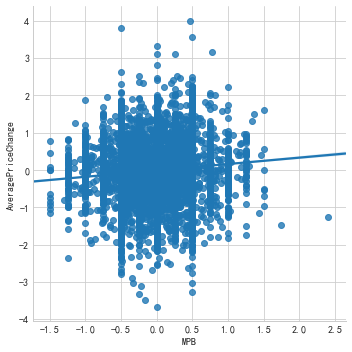

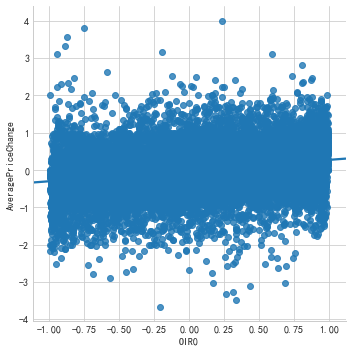

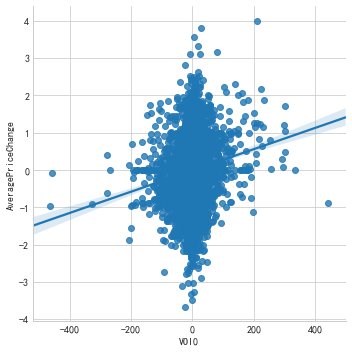

In [50]:
train_set = tick_data_all
#The idea is to train the model on the inSample and then use the model to trade on the outSample
X_train = train_set[featureList]
X_train = sm.add_constant(X_train) ## add an intercept (beta_0) to our model
y_train = train_set["AveragePriceChange"]

# Calibrate
model = sm.OLS(y_train, X_train).fit() ## sm.OLS(output, input)
predictions = model.predict(X_train)
y_fitted = model.fittedvalues
# Print out the statistics
print(model.summary())

#Plot the regression line as well alongside the data
sns.lmplot(x='MPB',y='AveragePriceChange',data=train_set, fit_reg=True) 

sns.lmplot(x='OIR0',y='AveragePriceChange',data=train_set, fit_reg=True) 

sns.lmplot(x='VOI0',y='AveragePriceChange',data=train_set, fit_reg=True) 

这次结果 R-squared:0.105 有所改善

## 使用其他模型看看

### 朴素贝叶斯分类

In [51]:
# https://github.com/fengdu78/lihang-code

## 因为是分类， 把 < -1的当作 -1， >1的当作1, [-1, 1]之间的当作0

def market_label(data):
    #print(data)
    if data < -1:
        return -1
    elif data > 1:
        return 1
    else :
        return 0
    return data

In [52]:
Y_train_label = y_train.apply(market_label)
Y_test_label = y_test.apply(market_label)
Y_test_label 

datetime
2019-09-11 21:00:05.091   -1
2019-09-11 21:00:05.596    0
2019-09-11 21:00:06.103   -1
2019-09-11 21:00:06.590    0
2019-09-11 21:00:07.093    0
2019-09-11 21:00:07.602    0
2019-09-11 21:00:08.096    0
2019-09-11 21:00:08.605   -1
2019-09-11 21:00:09.107   -1
2019-09-11 21:00:09.599    0
2019-09-11 21:00:10.108   -1
2019-09-11 21:00:10.600    0
2019-09-11 21:00:11.097    0
2019-09-11 21:00:11.608    0
2019-09-11 21:00:12.096    0
2019-09-11 21:00:12.596    0
2019-09-11 21:00:13.094    1
2019-09-11 21:00:13.597    1
2019-09-11 21:00:14.107    0
2019-09-11 21:00:14.607    0
2019-09-11 21:00:15.097    0
2019-09-11 21:00:15.606    0
2019-09-11 21:00:16.107    1
2019-09-11 21:00:16.595    1
2019-09-11 21:00:17.110    1
2019-09-11 21:00:17.598    1
2019-09-11 21:00:18.099    1
2019-09-11 21:00:18.609    0
2019-09-11 21:00:19.110    0
2019-09-11 21:00:19.599    0
                          ..
2019-09-11 22:59:13.126    0
2019-09-11 22:59:15.150    0
2019-09-11 22:59:17.644    0
2019-

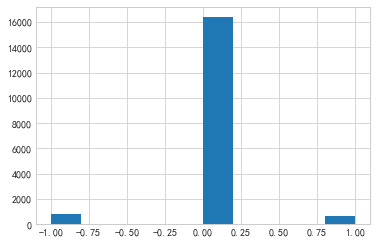

In [53]:
Y_train_label.hist()

In [54]:
X_train = X_train[featureList]
X_test = X_test[featureList]

In [55]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB, MultinomialNB # 伯努利模型和多项式模型

model = GaussianNB()

model.fit(X_train, Y_train_label)
y_predict = model.predict(X_test)

print(model.score(X_train, Y_train_label))
print(model.score(X_test, Y_test_label))


0.873190438783526
0.9203655352480418


In [56]:
i = 0
predice_right = 0
predice_all = 0
for y_hat in y_predict:
    #print(y_hat )
    if y_hat == 0:
        continue
        
    else:
        if y_hat == Y_test_label.iloc[i]:
            predice_right = predice_right +1
            predice_all = predice_all + 1
        else:
            predice_all = predice_all + 1
            
    i = i+1
    
print(predice_right/predice_all)

0.10784313725490197


### 使用随机森林

In [57]:

train_set = tick_data_all
#The idea is to train the model on the inSample and then use the model to trade on the outSample
X_train = train_set[featureList]
y_train = train_set["AveragePriceChange"]


import random

RANDOM_STATE=42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score, roc_auc_score

# RandomForestRegressor 我们做的不是分类而是回归，需要支持浮点型 
model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train, y_train.values.ravel())

y_predict = model.predict(X_test)
print("Traing Score:%f"%model.score(X_train,y_train))
print("Testing Score:%f"%model.score(X_test,y_test))
y_predict

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Traing Score:0.818373
Testing Score:0.815428


array([-1.19  , -0.4175, -0.6925, ..., -0.3525, -0.3   , -0.445 ])

In [58]:
y_test

datetime
2019-09-11 21:00:05.091   -1.900
2019-09-11 21:00:05.596   -0.975
2019-09-11 21:00:06.103   -1.100
2019-09-11 21:00:06.590   -0.175
2019-09-11 21:00:07.093    0.275
2019-09-11 21:00:07.602    0.250
2019-09-11 21:00:08.096   -0.250
2019-09-11 21:00:08.605   -1.250
2019-09-11 21:00:09.107   -1.225
2019-09-11 21:00:09.599   -0.175
2019-09-11 21:00:10.108   -1.700
2019-09-11 21:00:10.600   -0.200
2019-09-11 21:00:11.097   -0.200
2019-09-11 21:00:11.608   -0.175
2019-09-11 21:00:12.096   -0.125
2019-09-11 21:00:12.596   -0.075
2019-09-11 21:00:13.094    1.025
2019-09-11 21:00:13.597    1.125
2019-09-11 21:00:14.107    0.175
2019-09-11 21:00:14.607    0.225
2019-09-11 21:00:15.097    0.800
2019-09-11 21:00:15.606    0.875
2019-09-11 21:00:16.107    2.050
2019-09-11 21:00:16.595    2.225
2019-09-11 21:00:17.110    2.400
2019-09-11 21:00:17.598    2.000
2019-09-11 21:00:18.099    1.050
2019-09-11 21:00:18.609    0.050
2019-09-11 21:00:19.110   -0.475
2019-09-11 21:00:19.599    0.025
 

### 支持向量机SVM和支持向量回归SVR

In [59]:
from sklearn import svm
# https://blog.csdn.net/v_JULY_v/article/details/7624837#commentBox
# https://github.com/cjlin1/libsvm
model = svm.SVR()
model.fit(X_train, y_train.values.ravel())
y_predict = model.predict(X_test)
print(model.score(X_train, y_train.values.ravel()))
print(model.score(X_test, y_test.values.ravel()))

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.873722636699264
0.8838285071672928


### 得分挺高的，真实情况呢？
### 改为分类再做测试，进行评价, 因为数据偏差问题：太多为0 的数据，造成了得分很高的假象。需要重新计算得分

In [60]:

import random

RANDOM_STATE=42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score, roc_auc_score

# RandomForestRegressor 我们做的不是分类而是回归，需要支持浮点型 
model = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train, Y_train_label)

y_predict = model.predict(X_test)
print("Traing Score:%f"%model.score(X_train,Y_train_label))
print("Testing Score:%f"%model.score(X_test,Y_test_label))

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Traing Score:0.988553
Testing Score:0.992950


In [61]:
i = 0
predice_right = 0
predice_all = 0
for y_hat in y_predict:
    #print(y_hat )
    if y_hat == 0:
        continue
        
    else:
        if y_hat == Y_test_label.iloc[i]:
            predice_right = predice_right +1
            predice_all = predice_all + 1
        else:
            predice_all = predice_all + 1
            
    i = i+1
    
print(predice_right/predice_all)

0.05825242718446602


In [62]:
from sklearn import svm

model = svm.SVC()
model.fit(X_train, Y_train_label)
y_predict = model.predict(X_test)
print(model.score(X_train, Y_train_label))
print(model.score(X_test, Y_test_label))

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9846257434631355
0.9869451697127938


In [63]:
i = 0
predice_right = 0
predice_all = 0
for y_hat in y_predict:
    #print(y_hat )
    if y_hat == 0:
        continue
        
    else:
        if y_hat == Y_test_label.iloc[i]:
            predice_right = predice_right +1
            predice_all = predice_all + 1
        else:
            predice_all = predice_all + 1
            
    i = i+1
    
print(predice_right/predice_all)

0.06077348066298342


### 使用隐马尔可夫

In [64]:
# pip install -U  hmmlearn
# https://www.ricequant.com/community/topic/788/hmm%E5%9C%A8%E8%82%A1%E7%A5%A8%E4%B8%8A%E7%9A%84%E7%AE%80%E5%8D%95%E5%BA%94%E7%94%A8/49?page=1
from hmmlearn.hmm import GMMHMM,GaussianHMM
model = GaussianHMM(n_components= 9, covariance_type="diag", n_iter=10000).fit(X_train)
hidden_states = model.predict(X_test)


In [65]:
print(hidden_states)
print(model.startprob_)
print(model.transmat_)

[5 6 6 ... 1 1 1]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[[8.14276228e-001 0.00000000e+000 4.55817920e-003 1.55777792e-003
  4.85970650e-011 5.84304615e-002 6.93628549e-003 1.53495476e-002
  9.88915198e-002]
 [0.00000000e+000 8.19478095e-001 6.64943542e-003 4.22128775e-003
  4.44570666e-003 6.68306188e-002 0.00000000e+000 1.30624219e-002
  8.53124344e-002]
 [1.98932611e-100 5.51126810e-002 6.30205433e-001 3.57237802e-030
  1.76513393e-002 1.28928768e-001 3.52450494e-002 1.04324191e-006
  1.32855686e-001]
 [1.54425104e-189 2.79376251e-002 6.65354324e-001 6.03896330e-016
  9.02075286e-002 2.38602759e-002 1.46909887e-001 1.88238841e-168
  4.57303594e-002]
 [3.11139118e-003 2.27534310e-003 1.14993977e-001 2.84604085e-002
  7.88431536e-001 8.01659069e-004 3.32070585e-002 1.74148198e-002
  1.13038068e-002]
 [1.16739589e-002 1.57755557e-002 1.97897097e-030 9.69321401e-004
  5.92589579e-111 7.83489506e-001 9.60912804e-003 2.27943741e-006
  1.78480251e-001]
 [2.36469753e-001 0.00000000e+000 3.08816460e-0

C:\Anaconda3\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


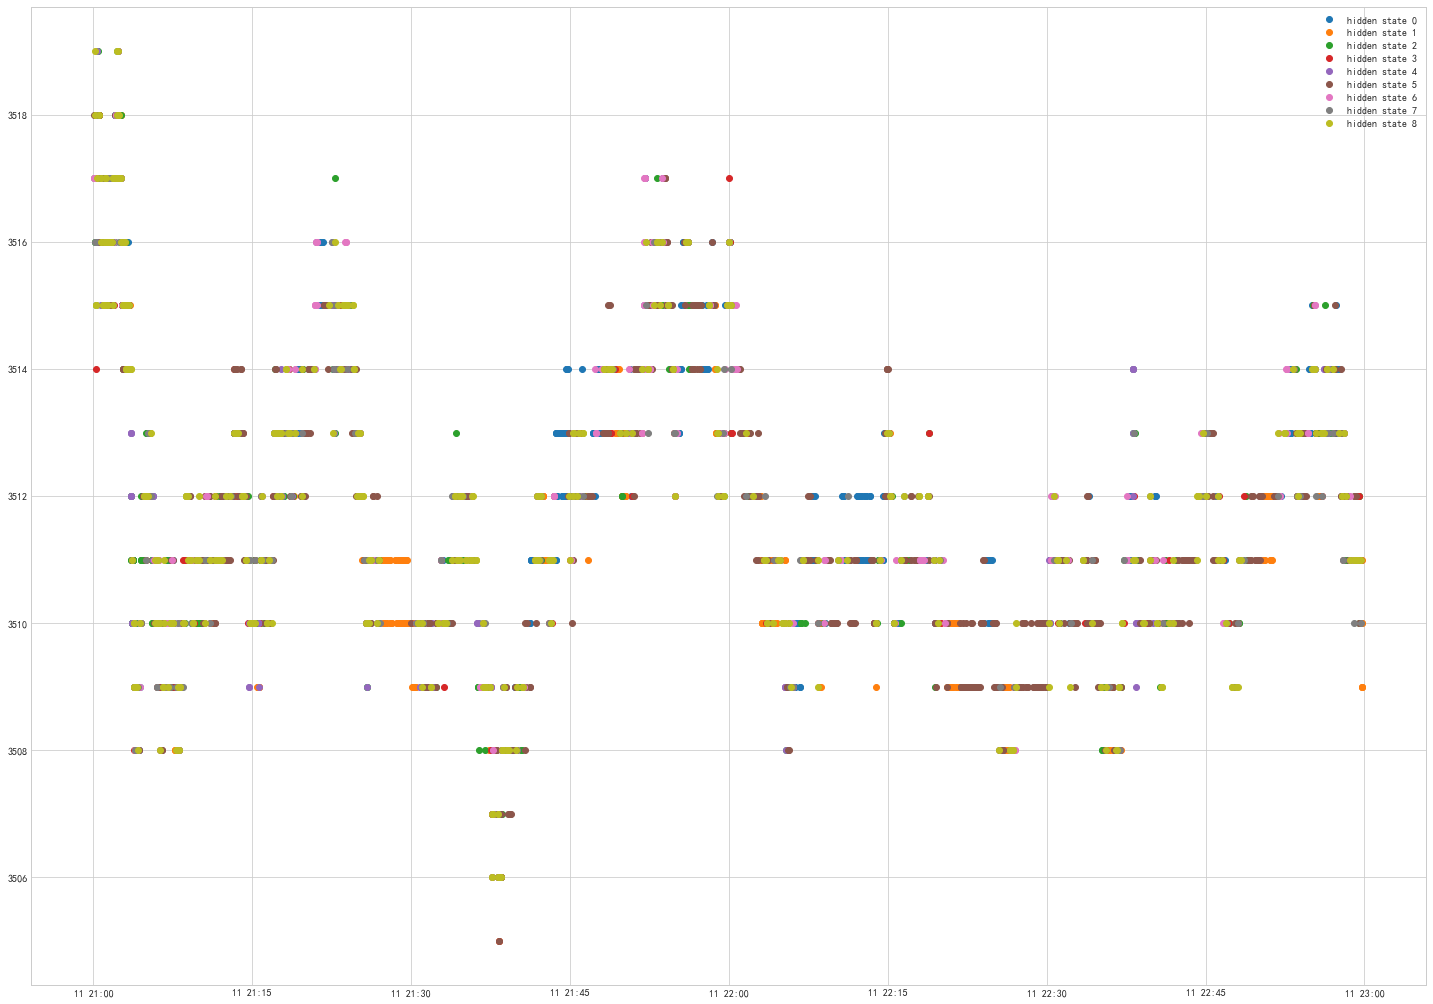

In [66]:
plt.figure(figsize=(25, 18)) 
# 遍历状态
for i in range(model.n_components):
    # 得到状态的序号
    idx = (hidden_states==i)
    # 打印此类状态的所有数据: 时间，价格
    plt.plot_date(X_test.index[idx], test_set["LastPrice"][idx],'o',label='hidden state %d'%i,lw=2)
    plt.legend(loc="left")

C:\Anaconda3\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


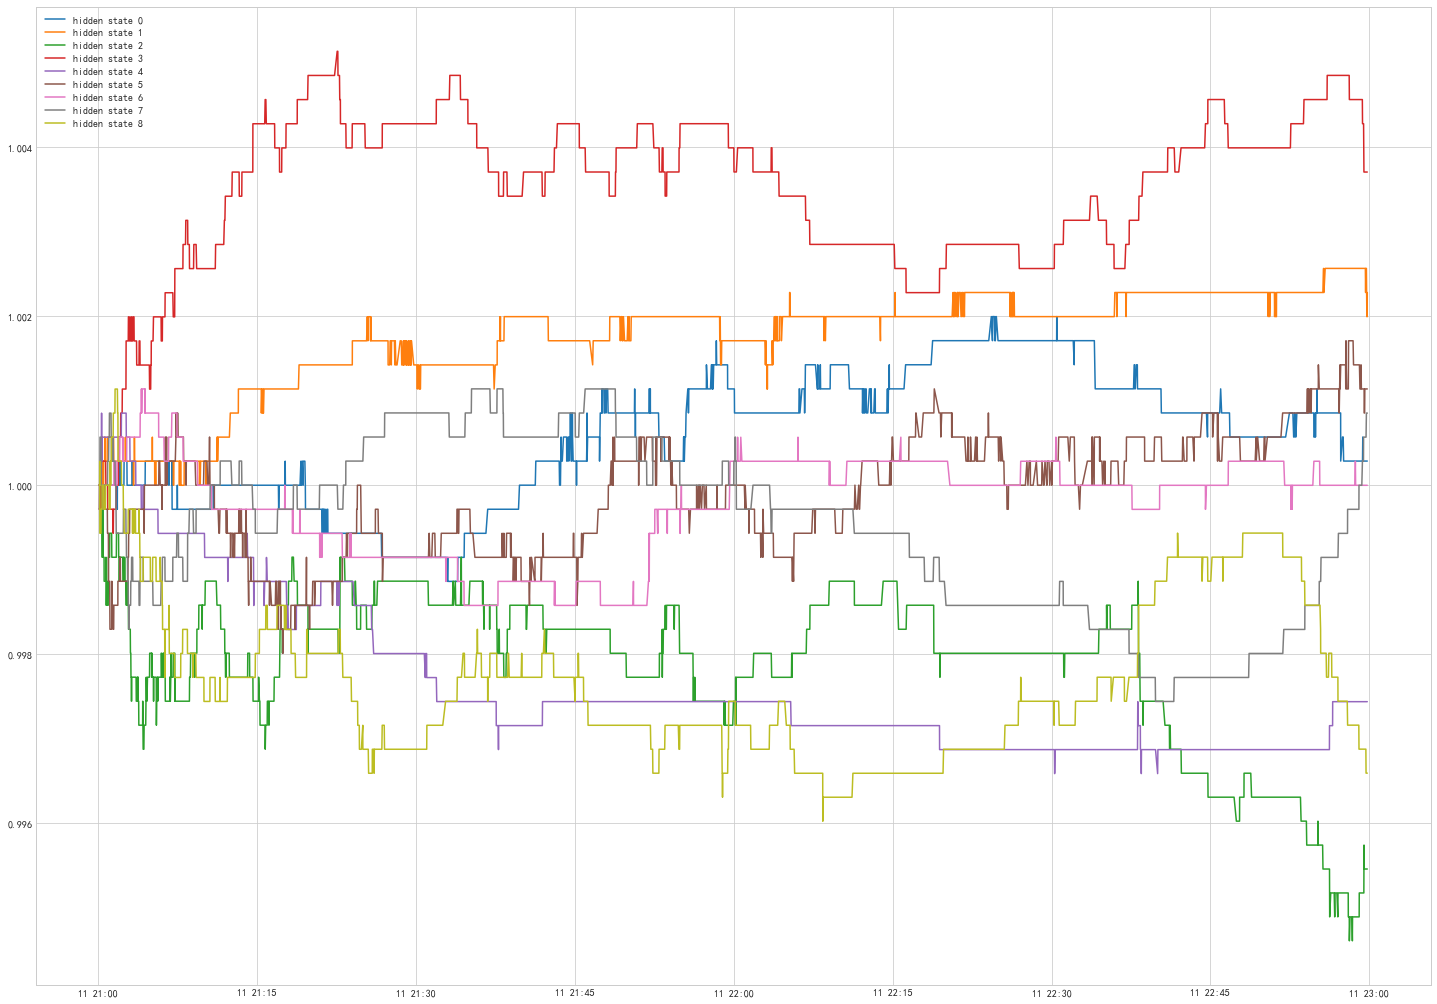

In [67]:
daily_log_returns = np.log(test_set["LastPrice"].pct_change()+1)

res = pd.DataFrame({'Date':test_set.index,'logRet_1':daily_log_returns,'state':hidden_states}).set_index('Date')
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    idx = (hidden_states==i)
    pos = np.append(0, idx[:-1])#第二天进行买入操作
    df = res.logRet_1
    res['state_ret%s'%i] = df.multiply(pos)
    plt.plot_date(test_set.index, np.exp(res['state_ret%s'%i].cumsum()),'-',label='hidden state %d'%i)
    plt.legend(loc="left")


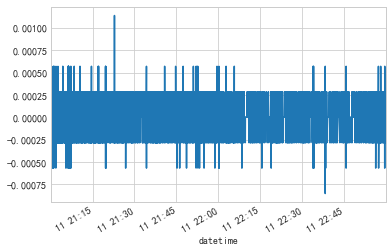

In [68]:
daily_log_returns.plot()

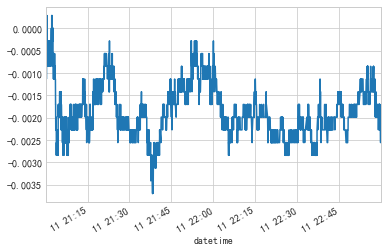

In [69]:
daily_log_returns.cumsum().plot()

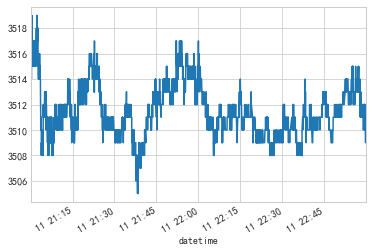

In [70]:
test_set["LastPrice"].plot()

###  因为HMM模型对输入的多维度观测变量进行处理后，只负责分出几个类别，而并不会定义出每种类别的实际含义。所以我们从图形中做出上述的判断。 人工主观找出那个序号是上涨，哪个是下跌

### 可以根据不同的状态，进行开仓平仓。

In [71]:
long = (hidden_states==3) + (hidden_states == 4) #做多
short = (hidden_states==0)   #做空
long

array([False, False, False, ..., False, False, False])

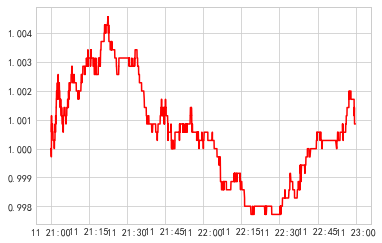

In [72]:
optlong = np.append(0,long[:-1]) #第二天才能操作
optshort = np.append(0,short[:-1]) #第二天才能操作

res['ret'] =  df.multiply(optlong) - df.multiply(optshort)
plt.plot_date(test_set.index,np.exp(res['ret'].cumsum()),'r-')

## 打印买卖点位

### 买卖点按照排序的定位位置，放置到相应的时间

In [73]:
longSeries = pd.Series(long,index=test_set.index)
shortSeries = pd.Series(short,index=test_set.index)

test_set["longSeries"] = longSeries
test_set["shortSeries"] = shortSeries

In [74]:
test_set.to_csv("outSample.csv")
test_set

,logtime,InstrumentID,LastPrice,Volume,Turnover,OpenInterest,BidPrice1,BidVolume1,AskPrice1,AskVolume1,TradingDay,UpdateTime,UpdateMillisec,date_phase,SecondOfDay,date_time_phase,spread,mid_price,dmid_price,AveragePriceChange,dBid_price,dAsk_price,bid_CV,ask_CV,VOI,DeltaVOI,OIR,DeltaOIR,dVol,dTO,AvgTrade_price,MPB,VOI0,OIR0,R0,VOI1,OIR1,VOI2,OIR2,VOI3,OIR3,VOI4,OIR4,VOI5,OIR5,longSeries,shortSeries
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-11 21:00:05.091,20190911210005091,hc2001,3518.0,2544,8.950948e+07,528124.0,3518.0,9,3519.0,46,20190912,21:00:05,0,20190911,75605,3,1.0,3518.5,0.5,-1.900,1.0,0.0,9.0,2.0,7.0,21.0,-0.672727,-0.101299,4.0,140740.0,3518.500000,0.250000,7.000000,-0.672727,0.250000,-14.0,-0.571429,28.000000,0.217391,6.000000,0.061224,-119.000000,-0.966942,-168.000000,-0.696970,False,False
2019-09-11 21:00:05.596,20190911210005596,hc2001,3517.0,2600,9.147944e+07,528100.0,3517.0,13,3518.0,28,20190912,21:00:05,500,20190911,75605,3,1.0,3517.5,-1.0,-0.975,-1.0,-1.0,0.0,28.0,-28.0,-35.0,-0.365854,0.306874,56.0,1969960.0,3517.785714,-0.214286,-28.000000,-0.365854,-0.214286,7.0,-0.672727,-14.000000,-0.571429,28.000000,0.217391,6.000000,0.061224,-119.000000,-0.966942,False,False
2019-09-11 21:00:06.103,20190911210006103,hc2001,3517.0,2636,9.274576e+07,528116.0,3517.0,8,3518.0,28,20190912,21:00:06,0,20190911,75606,3,1.0,3517.5,0.0,-1.100,0.0,0.0,-5.0,0.0,-5.0,23.0,-0.555556,-0.189702,36.0,1266320.0,3517.555556,0.055556,-5.000000,-0.555556,0.055556,-28.0,-0.365854,7.000000,-0.672727,-14.000000,-0.571429,28.000000,0.217391,6.000000,0.061224,False,False
2019-09-11 21:00:06.590,20190911210006590,hc2001,3517.0,2692,9.471528e+07,528146.0,3516.0,30,3517.0,14,20190912,21:00:06,500,20190911,75606,3,1.0,3516.5,-1.0,-0.175,-1.0,-1.0,0.0,14.0,-14.0,-9.0,0.363636,0.919192,56.0,1969520.0,3517.000000,0.000000,-14.000000,0.363636,0.000000,-5.0,-0.555556,-28.000000,-0.365854,7.000000,-0.672727,-14.000000,-0.571429,28.000000,0.217391,False,False
2019-09-11 21:00:07.093,20190911210007093,hc2001,3517.0,2746,9.661406e+07,528158.0,3515.0,84,3517.0,16,20190912,21:00:07,0,20190911,75607,3,2.0,3516.0,-0.5,0.275,-1.0,0.0,0.0,2.0,-2.0,12.0,0.680000,0.316364,54.0,1898780.0,3516.259259,0.009259,-1.000000,0.340000,0.004630,-7.0,0.181818,-2.500000,-0.277778,-14.000000,-0.182927,3.500000,-0.336364,-7.000000,-0.285714,False,False
2019-09-11 21:00:07.602,20190911210007602,hc2001,3518.0,2866,1.008345e+08,528116.0,3515.0,83,3517.0,3,20190912,21:00:07,500,20190911,75607,3,2.0,3516.0,0.0,0.250,0.0,0.0,-1.0,-13.0,12.0,14.0,0.930233,0.250233,120.0,4220440.0,3517.033333,1.033333,6.000000,0.465116,0.516667,-1.0,0.340000,-7.000000,0.181818,-2.500000,-0.277778,-14.000000,-0.182927,3.500000,-0.336364,False,False
2019-09-11 21:00:08.096,20190911210008096,hc2001,3518.0,2954,1.039298e+08,528162.0,3515.0,82,3518.0,25,20190912,21:00:08,0,20190911,75608,3,3.0,3516.5,0.5,-0.250,0.0,1.0,-1.0,0.0,-1.0,-13.0,0.532710,-0.397522,88.0,3095340.0,3517.431818,1.181818,-0.333333,0.177570,0.393939,4.0,0.310078,-0.666667,0.226667,-4.666667,0.121212,-1.666667,-0.185185,-9.333333,-0.121951,False,False
2019-09-11 21:00:08.605,20190911210008605,hc2001,3518.0,2982,1.049149e+08,528158.0,3517.0,1,3518.0,42,20190912,21:00:08,500,20190911,75608,3,1.0,3517.5,1.0,-1.250,2.0,0.0,1.0,17.0,-16.0,-15.0,-0.953488,-1.486199,28.0,985040.0,3518.000000,1.000000,-16.000000,-0.953488,1.000000,-1.0,0.532710,12.000000,0.930233,-2.000000,0.680000,-14.000000,0.363636,-5.000000,-0.555556,False,False
2019-09-11 21:00:09.107,20190911210009107,hc2001,3519.0,3076,1.082219e+08,528168.0,3517.0,3,3518.0,1,20190912,21:00:09,0,20190911,75609,3,1.0,3517.5,0.0,-1.225,0.0,0.0,2.0,-41.0,43.0,59.0,0.500000,1.453488,94.0,3307040.0,3518.127660,0.627660,43.000000,0.500000,0.627660,-16.0,-0.953488,-1.000000,0.532710,12.000000,0.930233,-2.000000,0.680000,-14.000000,0.363636,False,False


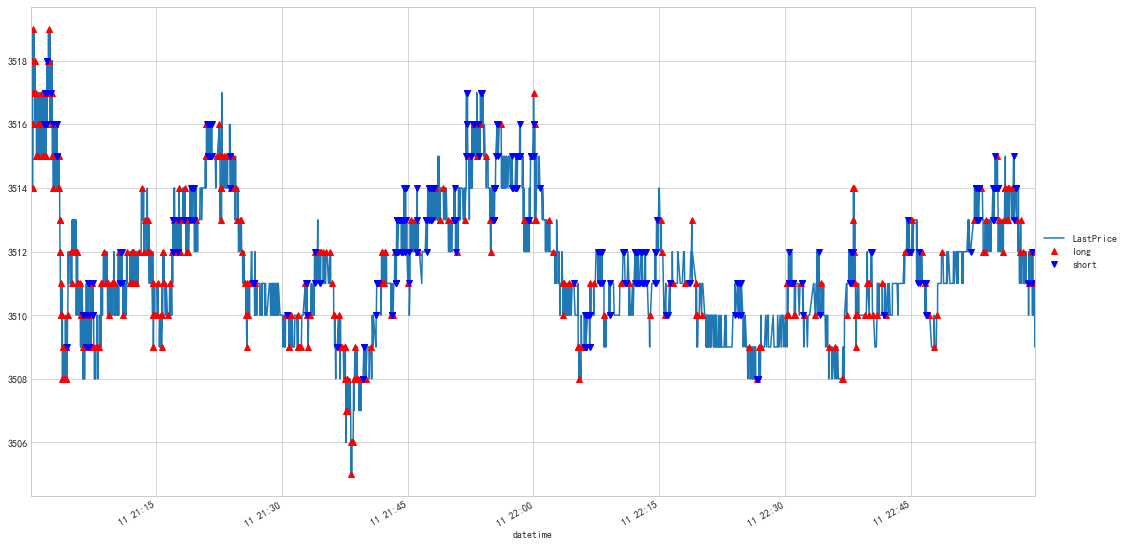

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10), sharex=True)

test_set["LastPrice"].plot(ax=ax, ls='-', label='LastPrice')
test_set[test_set.longSeries == 1]["LastPrice"].plot(color='r', marker='^', linestyle='None', label='long')
test_set[test_set.shortSeries == 1]["LastPrice"].plot(color='b', marker='v', linestyle='None', label='short')

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)
plt.show()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


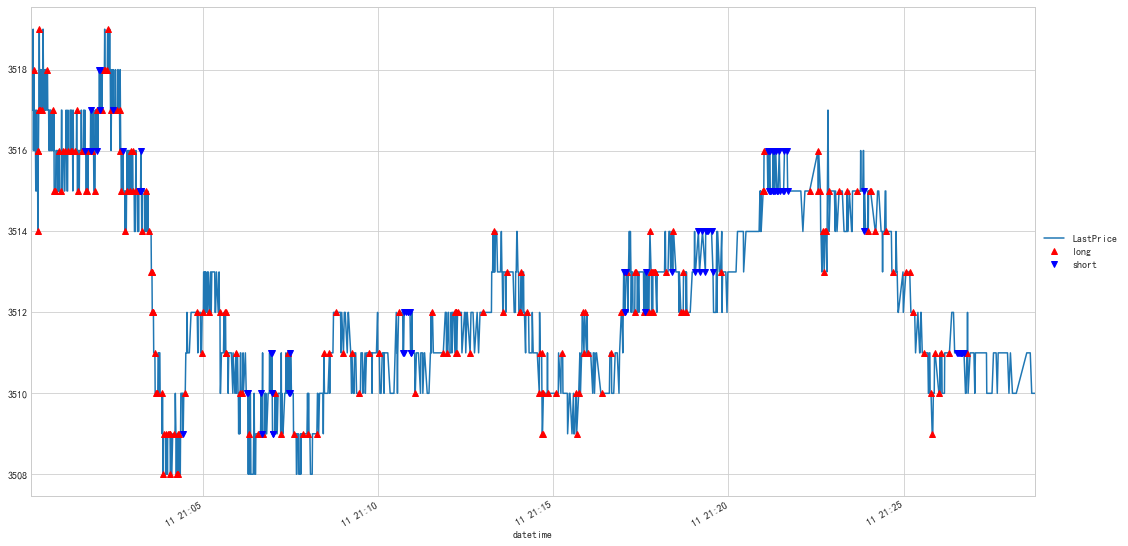

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10), sharex=True)

test_set[:1500]["LastPrice"].plot(ax=ax, ls='-', label='LastPrice')
test_set[:1500][test_set.longSeries == 1]["LastPrice"].plot(color='r', marker='^', linestyle='None', label='long')
test_set[:1500][test_set.shortSeries == 1]["LastPrice"].plot(color='b', marker='v', linestyle='None', label='short')

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)
plt.show()

### 开发一个策略

In [77]:
tradeSimulation = test_set[['mid_price', 'BidPrice1', 'AskPrice1', 'TradingDay','UpdateTime','UpdateMillisec', "longSeries", "shortSeries" ]]
import math
# 在平仓后，马上发（反向）开仓指令
close_and_reopen = True

TR_COST = 2.5 * 1e-5
trade_volume = 0
own = False
pos = 0
pnl = 0
trade_costs = 0
buy_price = 0
sell_price = 0

trade_volume = 0
trade_records = []
total_trade_pnl = []
key = "hc"
n = len(tradeSimulation)

strat = [0] * n
realized_pnl = [np.nan] * n

trade_at_mid = False

ask = tradeSimulation["mid_price"] if trade_at_mid else tradeSimulation['AskPrice1']
bid = tradeSimulation["mid_price"] if trade_at_mid else tradeSimulation['BidPrice1']

threshold = 1

for i in range(n - lags):
#     print(tradeSimulation['TradingDay'][i],
#                tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]), tradeSimulation["longSeries"][i], tradeSimulation["shortSeries"][i])
    if own == False and tradeSimulation["longSeries"][i] == 1:
        ## BUY to OPEN
        strat[i] = 1
        own = True
        pos = 1
        buy_price = ask[i]
        tc = buy_price * TR_COST
        trade_costs = trade_costs + tc
        trade_volume = trade_volume + 1
        trade_records.append((key, tradeSimulation['TradingDay'][i],
                              tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]),
                              'BUY', 1, buy_price, tc, 0))
        print((key, tradeSimulation['TradingDay'][i],
               tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]), 'BUY', 1,
               buy_price, tc, 0))
    elif own == False and  tradeSimulation["shortSeries"][i] == 1:
        ## SELL to OPEN
        strat[i] = -1
        own = True
        pos = -1
        sell_price = bid[i]
        tc = sell_price * TR_COST
        trade_costs = trade_costs + tc
        trade_volume = trade_volume + 1
        trade_records.append((key, tradeSimulation['TradingDay'][i],
                              tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]),
                              'SHORT', 1, sell_price, tc, 0))
        print((key, tradeSimulation['TradingDay'][i],
               tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]), 'SHORT', 1,
               sell_price, tc, 0))
    elif own == True and pos == 1 and  buy_price < bid[i]:
        ## SELL to CLOSE
        strat[i] = -1
        own = False
        pos = 0
        sell_price = bid[i]
        tc = tc + sell_price * TR_COST
        trade_costs = trade_costs + tc
        trade_pnl = sell_price - buy_price - tc
        pnl = pnl + trade_pnl
        trade_volume = trade_volume + 1
        total_trade_pnl.append(trade_pnl)
        trade_records.append((key, tradeSimulation['TradingDay'][i],
                              tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]),
                              'SELL', 1, sell_price, tc, trade_pnl))
        print((key, tradeSimulation['TradingDay'][i],
               tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]), 'SELL', 1,
               sell_price, tc, trade_pnl))
        # 平完了，没仓位了，如果时间在交易区间内，可以开仓
        if close_and_reopen:
            ## SELL to OPEN
            strat[i] = -2
            own = True
            pos = -1
            sell_price = bid[i]
            tc = sell_price * TR_COST
            trade_costs = trade_costs + tc
            trade_pnl = sell_price - buy_price - tc
            pnl = pnl + trade_pnl
            trade_volume = trade_volume + 1
            trade_records.append((key, tradeSimulation['TradingDay'][i],
                                  tradeSimulation['UpdateTime'][i] + '.' + str(
                                      tradeSimulation['UpdateMillisec'][i]), 'SHORT', 1, sell_price, tc, 0))
        print((key, tradeSimulation['TradingDay'][i],
               tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]), 'SHORT', 1,
               sell_price, tc, 0))
    elif own == True and pos == -1 and  sell_price > ask[i]:
        ## BUY to CLOSE
        strat[i] = 1
        own = False
        pos = 0
        buy_price = ask[i]
        tc = tc + buy_price * TR_COST
        trade_costs = trade_costs + tc
        trade_pnl = sell_price - buy_price - tc
        pnl = pnl + trade_pnl
        trade_volume = trade_volume + 1
        total_trade_pnl.append(trade_pnl)
        trade_records.append((key, tradeSimulation['TradingDay'][i],
                              tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]),
                              'COVER', 1, buy_price, tc, trade_pnl))
        print((key, tradeSimulation['TradingDay'][i],
                              tradeSimulation['UpdateTime'][i] + '.' + str(tradeSimulation['UpdateMillisec'][i]),
                              'COVER', 1, buy_price, tc, trade_pnl))

        if close_and_reopen:
            ## BUY to OPEN
            strat[i] = 2
            own = True
            pos = 1
            buy_price = ask[i]
            tc = buy_price * TR_COST
            trade_pnl = sell_price - buy_price - tc
            pnl = pnl + trade_pnl
            trade_costs = trade_costs + tc
            trade_volume = trade_volume + 1
            trade_records.append((key, tradeSimulation['TradingDay'][i],
                                  tradeSimulation['UpdateTime'][i] + '.' + str(
                                      tradeSimulation['UpdateMillisec'][i]), 'BUY', 1, buy_price, tc, 0))
            print((key, tradeSimulation['TradingDay'][i],
                                  tradeSimulation['UpdateTime'][i] + '.' + str(
                                      tradeSimulation['UpdateMillisec'][i]), 'BUY', 1, buy_price, tc, 0))

    realized_pnl[i] = pnl

# check if we have a left-over position at end-of-day and close it
if sum(strat) == 1:
    if strat[n - 1] == 1:
        strat[n - 1] = 0
        trade_volume = trade_volume - 1
    else:
        strat[n - 1] = -1
        sell_price = bid[n - 1]
        tc = tc + sell_price * TR_COST
        trade_costs = trade_costs + tc
        trade_pnl = sell_price - buy_price - tc
        pnl = pnl + trade_pnl
        realized_pnl[n - 1] = pnl
        total_trade_pnl.append(trade_pnl)
        trade_volume = trade_volume + 1
        trade_records.append((key, tradeSimulation['TradingDay'][i],
                              tradeSimulation['UpdateTime'][n - 1] + '.' + str(
                                  tradeSimulation['UpdateMillisec'][n - 1]), 'SELL', 1, sell_price, tc, trade_pnl))
elif sum(strat) == -1:
    if strat[n - 1] == -1:
        strat[n - 1] = 0
        trade_volume = trade_volume - 1
    else:
        strat[n - 1] = 1
        buy_price = ask[n - 1]
        tc = tc + buy_price * TR_COST
        trade_costs = trade_costs + tc
        trade_pnl = (sell_price - buy_price) - tc
        pnl = pnl + trade_pnl
        realized_pnl[n - 1] = pnl
        total_trade_pnl.append(trade_pnl)
        trade_volume = trade_volume + 1
        trade_records.append((key, tradeSimulation['TradingDay'][i],
                              tradeSimulation['UpdateTime'][n - 1] + '.' + str(
                                  tradeSimulation['UpdateMillisec'][n - 1]), 'COVER', 1, buy_price, tc, trade_pnl))
        print((key, tradeSimulation['TradingDay'][i],
                              tradeSimulation['UpdateTime'][n - 1] + '.' + str(
                                  tradeSimulation['UpdateMillisec'][n - 1]), 'COVER', 1, buy_price, tc, trade_pnl))

# return stats
if math.isnan(realized_pnl[0]):
    realized_pnl[0] = 0

realized_pnl = pd.Series(realized_pnl).fillna(method='ffill').tolist()

value = {}
value['pnl'] = realized_pnl
value['strategy'] = strat
value['trade_records'] = trade_records
value['trade_volume'] = trade_volume
value['trade_pnl'] = total_trade_pnl
value['trade_costs'] = trade_costs

print("pnl: %d" % (pnl))
print("trade_volume: %d" % (trade_volume))

('hc', 20190912, '21:00:10.0', 'BUY', 1, 3519.0, 0.087975, 0)
pnl: -10
trade_volume: 2


### 如何保存和恢复scikit-learn训练的模型

In [78]:
import pickle
pkl_filename = "./svm_model.pkl"

with open(pkl_filename, 'wb') as fileout:
     pickle.dump(model, fileout)

with open(pkl_filename, 'rb') as filein:
     model2 = pickle.load(filein)
 

In [79]:
model2

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=9, n_iter=10000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [80]:
print(model2.score(X_test, y_test))

TypeError: slice indices must be integers or None or have an __index__ method

### 后面，使用历史数据，进行大批量测试


本文首先介绍了高频交易领域以及将用于测试交易策略的数据。通过检查订单不平衡（一种衡量市场中买卖订单大小差异的指标），我们通过使用线性最小二乘拟合20个时间步长（10秒）的平均价格来拟合线性模型，从而开发了一种简单的交易策略更改。我们已经表明，使用该线性模型预测未来价格变化和当预测大于1个报价时进行交易的策略具有很高的盈利能力。但是，在对该策略的收益进行了一些分析之后，我们发现其中大部分与市场上的总交易量密切相关。通过将线性模型扩展到包括两个新因素，我们进一步改善了该交易信号：订单不平衡率（衡量不平衡程度）和中间价格基础（均值回复过程）。我们还发现，在大多数情况下，大的点差表明价格变化很小，因此通过除以买卖价差来调整所有三个因素。

金融市场并非没有竞争的交易者，因此始终能够取得最佳交易对手价格（买价，买价）的假设是无效的。我们不可能总是能够为收到的每个交易信号采用最佳的交易对手价格。尽管计算机能够接收市场数据，使用模型系数计算交易信号，并在毫秒内做出交易决策，但是当订单被发送回交易所时，实际执行价格可能已经改变。即使提前执行几毫秒也可以产生更多可盈利的交易[14]。通过假设我们能够在50％的时间内获取交易对手价格或建立一个模型来模拟我们的市场竞争对手，可以提高交易模拟的准确性。最后，我们问这个策略是否可以被我们的竞争对手欺骗。鉴于订单不平衡并不是一种未知的交易策略，因此有些公司将试图利用该交易信号来利用交易者的优势。通过仔细查看我们用于生成交易信号的三个因素：成交量定单不平衡（VOI），定单不平衡率（OIR）和中间价格基准（MPB），我们发现VOI和OIR严重依赖于交易量。最佳出价和最佳要价。竞争对手可以通过快速提交大量的买或卖限价单并在此后立即取消来操纵这些数字。如果我们的交易算法由于竞争对手的欺骗技术而获得较大的买入或卖出量，我们将错误地计算出大订单不平衡（VOI和OIR），最终以错误生成的信号进行交易。

最后，我们可能要使用更复杂的统计技术进行模型选择，包括机器学习或逻辑回归，同时要记住，更好的统计模型不一定会转化为更好的利润。最终建议是应用机器学习技术来制定交易决策。如前几章所述，预测价格变化实质上是基于交易阈值q的交易策略的三项分类。我们可以利用三项式变量与实际价格变化之间的高度相关性。代替使用线性模型来预测连续变量，我们可以应用几种机器学习技术中的一种来构建三项分类器，例如逻辑回归，支持向量机或随机森林。但是，鉴于高频交易中有大量数据，将数据分为训练集和测试集非常重要，以确保交易策略不会使用过分分类的分类器来做出决策。

### 参考论文：

 Irene Aldridge. High-Frequency Trading: A Practical Guide to Algorithmic Strategies and Trading Systems. John Wiley & Sons, Inc, 2010.


Am´elie Charles and Olivier Darn´e. Variance ratio tests of random walk: An overview. Journal of Economic Surveys, 23(3):503–527, 2009.


Tarun Chordia, Richard Roll, and Avanidhar Subrahmanyam. Order imbalance, liquidity, and market returns. Journal of Financial Economics, 65:111–130, 2002

Tarun Chordia and Avanidhar Subrahmanyam. Order imbalance and individual stock returns: Theory and evidence. Journal of Financial Economics, 72:485– 518, 2004.


Rama Cont, Arseniy Kukanov, and Sasha Stoikov. The price impact of order book events. Journal of Financial Econometrics, 12(1):47–88, 2014.


Martin D. Gould, Mason A. Porter, Stacy Williams, Mark McDonald, Daniel J. Fenn, and Sam D. Howison. Limit order books. Quantitative Finance, 13(11):1709–1742, 2013.


Han-Ching Huang, Yong-Chern Su, and Yi-Chun Liu. The performance of imbalance-based trading strategy on tender o↵er announcement day. Investment Management and Financial Innovations, 11(2):38–46, 2014

 Jonathan Karpo↵. The relation between price changes and trading volume: A survey. Journal of Financial and Quantitative Analysis, 22(1):109–126, 1987.

Charles M.C. Lee and Mark J. Ready. Inferring trade direction from intraday data. The Journal of Finance, 46:733–747, 1991.


Xuan Liu. Stationary processes and hft. Master’s thesis, University of Oxford, 2015.


Rahul Ravi and Yuqing Sha. Autocorrelated Order-Imbalance and Price Momentum in the Stock Market. International Journal of Economics and Finance, 6(10):39–54, 2014.


Ruey S. Tsay. Analysis of Financial Time Series. John Wiley & Sons, Inc, 2010

Geroge H.K. Wang and Jot Yau. Trading volume, bid-ask spread, and price volatility in futures markets. Journal of Futures Markets, 20(10):943–970, 2000.


 Zhaodong Wang and Weian Zheng. High-Frequency Trading and Probability Theory. World Scientiﬁc Publishing Co. Pte. Ltd, 2015.
